In [1]:
from collections import OrderedDict, deque
import numpy as np
import itertools
import networkx as nx
from networkx.drawing.nx_pydot import write_dot
from networkx.drawing.nx_pydot import pydot_layout
import matplotlib as mpl
# mpl.use('pdf')
import matplotlib.pylab as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea, DrawingArea
from matplotlib.patches import Circle

In [2]:
mpl.rcParams['figure.dpi'] = 1600
mpl.rcParams['figure.figsize'] = (
    20,
    20
    )
mpl.rcParams['savefig.transparent'] = True

In [3]:
# Import Images
Images = dict()
from glob import glob
for item in glob("./AllPatterns/*.png"):
    try:
        Filename = item.split("/")[2]
        print Filename
        Images[int(Filename[:2])] = Filename
    except:
        print Filename
        raise SystemExit

52  1 1 0.1 0 0.png
51  1 1 0.0 1 1.png
56  1 1 1.0 0 0.png
53  1 1 0.1 0 1.png
54  1 1 0.1 1 0.png
50  1 1 0.0 1 0.png
32  1 0 0.0 0 0.png
48  1 1 0.0 0 0.png
36  1 0 0.1 0 0.png
63  1 1 1.1 1 1.png
60  1 1 1.1 0 0.png
62  1 1 1.1 1 0.png


In [4]:
def SpeciesToRepString(Species, N=3):
    if isinstance(Species, np.ndarray):
        Out = map(str, Species.flatten())
        Out = ",".join(Out[:N]) + ";" + ",".join(Out[N:])
        return Out
    if isinstance(Species, int):
        Out = [x for x in str(bin(Species)[2:].zfill(N*2))]
        Out = ",".join(Out[:N]) + ";" + ",".join(Out[N:])
        return Out
    Cur = Species.split(" ")
    if len(Cur) == 2 and len(Cur[0]) == 4*N-1:
        return Cur[0]
    if Cur[0] == Species:
        return Species
    return False

def SpeciesToArrays(Species, N=3):
    Cur = SpeciesToRepString(Species, N)
    Cur = np.array([x.split(",") for x in Cur.split(";")], dtype="b")
    return Cur

def SpeciesArrayToInt(Species, N=3):
    Species = SpeciesToArrays(Species, N)
    return int(np.sum([x*(2**n) for n,x in enumerate(Species.flatten()[::-1])]))

def SpeciesRepToInt(Species, N=3):
    return SpeciesArrayToInt(Species, N)

def Symmetries(Species, N=3, Unique = True, Ints=False, Sorted=True):
    '''
    Symmetries(Species, N=3, Unique = True, Ints=False, Sorted=True)
    Sorted = False results in the index consistantly representing the same symmetry
    Results are sorted, so first entry is always the "Cannonical Rep"
    '''
    Cur = SpeciesToArrays(SpeciesToRepString(Species), N)
    Syms = []
    Syms.append(Cur) # Identity
    for I in range(1,N): # Rotational Symmetries (C_N)
        Syms.append(np.roll(Cur, I, axis=1))
#     if (Cur[0] + Cur[1] != 2).all(): # Avoid directional Bonds
    for I in range(len(Syms)): # Reflection Symmetries (Not sure these should be allowed due to directional bonds) Allowing for now
        Syms.append(Syms[I][::-1])
#     else:
#         for I in range(len(Syms)): # Always return the same number even if not unique ;)
#             Syms.append(Syms[I])
    
#     for S in Syms:
#         print("{} : {} : {}".format(SpeciesArrayToInt(S),SpeciesToRepString(S),S))
    if Unique:
#         print set(map(SpeciesArrayToInt,Syms))
        Out = map(SpeciesToArrays,set(map(SpeciesArrayToInt,Syms)))
    else:
        Out = Syms
    if Sorted:
        Out = sorted(Out, key=SpeciesArrayToInt)
    else:
        pass
    Out = map(SpeciesToRepString, Out[::-1])
    if Ints:
        return map(SpeciesArrayToInt,Out)
    else:
        return map(SpeciesToRepString,Out)


In [5]:
def SpeciesToIndex(S, Species):
    return int(np.where(np.array(Species.values())==S)[0])

def SpeciesToName(S, Species):
    return Species.values()[S]

class Probabilities(object):
    def __init__(self, Data, Concentrations=False):
        self.Data = Data
        self.ProteinsInSpecies = [sum(x == "1" for x in Data.Species.values()[i]) for i in range(Data.SpeciesCount)]
        self._GenReactionsByProduct()
        self.UpdateNorms(Concentrations)

    def LookupReaction(self, Product, R1 = -1, R2 = -1):
        Out = deque()
        for R in self.Data.Reactions:
            if R[3] == Product:
                Out.append(R)
        if R1 == -1 and R2 == -1:
            return Out
        R1 = int(R1)
        R2 = int(R2)
        for R in Out:
            if R[0] == R1 and R[1] == R2:
                return R
            if R[1] == R1 and R[0] == R2:
                return R
        return False

    def _GenReactionsByProduct(self):
        ReactionsByProduct = OrderedDict()
        for Species in self.Data.SpeciesConvert.values():
            for R in self.LookupReaction(Species):
                try:
                    ReactionsByProduct[Species].append(R)
                except:
                    ReactionsByProduct[Species] = list()
                    ReactionsByProduct[Species].append(R)
        self.ReactionsByProduct = ReactionsByProduct

    def UpdateNorms(self, Concentrations = False): 
        # Generate the normalization factors (Return list in the same order as the Data.Species list)
        if hasattr(Concentrations, '__iter__'):
            NormsBySpecies = np.zeros(len(Concentrations))
        else:
            Concentrations = np.ones(self.Data.SpeciesCount)
            NormsBySpecies = np.zeros(self.Data.SpeciesCount)

        for i, Rs in self.ReactionsByProduct.items():
            #print "{} : {}".format(i,Rs)
            for R in Rs:
                # R[2]: Forward
                # R[0]: Reactant 1
                # R[1]: Reactant 2
                # R[3]: Product
                NormsBySpecies[i] += R[2]*Concentrations[R[0]]*Concentrations[R[1]]
                #print "{} : {}".format(R, NormsBySpecies[i])
        self.Concentrations = Concentrations 
        self.NormsBySpecies = NormsBySpecies

    def UpdateConcentrations(self, Fraction, Concentration): 
        #RealConc = np.zeros_like(Fraction)
        RealConc = Fraction*Concentration/self.ProteinsInSpecies
        self.UpdateNorms(RealConc)

    def ReactionFlux(self, Product, R1, R2):
        Forward = self.LookupReaction(Product, R1, R2)
        if hasattr(Forward, '__iter__'):
            Forward = Forward[2]
        else:
            print "Reaction for P: {} R1: {} R2: {} Not Found!!!!".format(Product, R1, R2)
        if self.Concentrations[R1]*self.Concentrations[R2] != 0.0:
            return Forward*self.Concentrations[R1]*self.Concentrations[R2]/(self.NormsBySpecies[Product])
        return 0.0

    def NodeFlux(self, Graph, Node = "Root"):
        if Node == "Root":
            Node = self.Data.Species.values()[-1] # Root Node Name
        Product = nx.get_node_attributes(Graph,"Product")[Node]
        R1 = nx.get_node_attributes(Graph,"Reactant1")[Node]
        R2 = nx.get_node_attributes(Graph,"Reactant2")[Node]
        return self.ReactionFlux(Product,R1,R2)

    def PathIndependentFlux(self, Graph, Probability = True):
        Product = nx.get_node_attributes(Graph,"Product").values()
        R1 = nx.get_node_attributes(Graph,"Reactant1").values()
        R2 = nx.get_node_attributes(Graph,"Reactant2").values()
        Flux = 1.0
        for i in range(len(Product)):
            Flux *= self.ReactionFlux(Product[i],R1[i],R2[i])
        if not Probability:
            # Remove normalization from last step
            Flux *= self.NormsBySpecies[-1]
        return Flux

    def GetChildren(self, Graph, Node):
        return Graph.successors(Node)


In [6]:
class ImportedData(object):
    def __init__(self, N = 3):
        self.N = N
        self.SymCount = 2*N
        self.GetSDataFromFiles("species{}".format(N))
        self.GetRDataFromFiles("react{}".format(N))
        #         Sort Species
        self.MonomerCount = int(len(self.Species.values()[0])/2)
    
    def GetSDataFromFiles(self, filename):
        try:
            self.Species = OrderedDict()
            with open(filename,"r") as SpeciesFile:
                SpeciesList = SpeciesFile.read().strip().split("\n")
                for S in SpeciesList:
                    L = S.split(";;")
                    self.Species[int(L[0])] = L[1]
        
            self.Species = OrderedDict(sorted(self.Species.items(), key=lambda x: x[0]))
            self.SpeciesConvert = OrderedDict()
            for i, S in enumerate(map(int,self.Species.keys())):
                self.SpeciesConvert[int(S)] = i

            self.SpeciesCount = len(self.Species.keys())
            self.SpeciesNumbers = list(np.array([Symmetries(x, Ints=True, Unique=False, Sorted=True)[::-1] for x in self.Species.keys()]).flatten())
            
        except:
            return False

    def GetRDataFromFiles(self, filename):
        try:
            self.Reactions = []
            with open(filename,"r") as ReactFile:
                ReactList = ReactFile.read().strip().split("\n")
                ReactList = map(lambda x: x.split("\t"), ReactList)
                for R in ReactList:
                    R = map(lambda x: x.split(";;"), R)
                    R = map(lambda x: x[0], R)
                    R = map(lambda x: x.split(","), R)
                    # Drop Representation
                    R = list(itertools.chain(*R))
                    R = map(int, R)
                    R[0]=self.SpeciesConvert[R[0]]
                    R[1]=self.SpeciesConvert[R[1]]
                    if R[0] > R[1]:
                        R0 = R[0]
                        R1 = R[1]
                        R[0] = R1
                        R[1] = R0
                    R[3]=self.SpeciesConvert[R[3]]
                    self.Reactions.append(R)

                # Sort Reactions by Product, R1, R2 (R1 is always less than R2)
                SortList = map(list,list(np.array(self.Reactions)[:,(3,0,1)]))
                L = range(len(SortList))
                for i in L:
                    SortList[i].append(i)
                SortOrder = np.array(sorted(SortList))[:,3]
                self.Reactions = map(list,list(np.array(self.Reactions)[SortOrder]))
                
                return True
        except Exception as e:
            print e
            return False

    def ReactionValue(self, Node, Graph): # Used for cannonical definition
        def AddToNode(N):
            if N >= 0:
                ##  0  1 2 3  4  5 6
                ## R1 R2 F P B1 B2 R
                Graph.add_node(Node, {
                                            "RIndex":N,
                                            "Forward":self.Reactions[N][2],
                                            "Reverse":self.Reactions[N][6],
                                            "BondType1":self.Reactions[N][4],
                                            "BondType2":self.Reactions[N][5],
                                            "Product":self.Reactions[N][3],
                                            "Reactant1":self.Reactions[N][0],
                                            "Reactant2":self.Reactions[N][1],
                                            })
            else:
                Graph.add_node(Node, RIndex = -1)
#         P = SpeciesToIndex(Node.split(" ")[0], self.Species)
#         print Node
        PC = self.CannonicalSpecies(Node.split(" ")[0], Ints=True)
#         print PC
        P = SpeciesToIndex(SpeciesToRepString(PC), self.Species)
#         print P
#         print self.CannonicalSpecies(P)
#         if P == min(self.SpeciesConvert.values()):
        if SpeciesRepToInt(PC) == 32:
#             print "Found Monomer"
            AddToNode(-1)
            return 0
        #if P == min(self.SpeciesConvert.values()) or P == max(self.SpeciesConvert.values()):
        #    AddToNode(0)
        #    return 0
        try:
            R1, R2 = Graph.succ[Node].keys()
        except:
            print "---------Graph Node has Wrong Number of Children-----------"
            print Graph.nodes()
            print Node
            
#         print R1
        print self.CannonicalSpecies(R1)
#         print R2
        print self.CannonicalSpecies(R2)
        R1 = SpeciesToIndex(SpeciesToRepString(self.CannonicalSpecies(R1.split(" "))), self.Species)
        R2 = SpeciesToIndex(SpeciesToRepString(self.CannonicalSpecies(R2.split(" "))), self.Species)
#         R1 = SpeciesToIndex(Symmetries(R1.split(" ")[0], N=self.N, Ints=False, Sorted=True)[0], self.Species)
#         R2 = SpeciesToIndex(Symmetries(R2.split(" ")[0], N=self.N, Ints=False, Sorted=True)[0], self.Species)
#         R1 = SpeciesToIndex(R1.split(" ")[0], self.Species)
#         R2 = SpeciesToIndex(R2.split(" ")[0], self.Species)
        for i, R in enumerate(self.Reactions):
            if P == R[3]:
                if R1 in R[:2] and R2 in R[:2]:
                    AddToNode(i)
                    return i+1
        print "---------"
        print P
        print R1
        print R2
        raise KeyError

#     def ReactionValue(self, Node, Graph): # Used for cannonical definition
#         def AddToNode(N):
#             if N >= 0:                
#                 ##  0  1 2 3  4  5 6
#                 ## R1 R2 F P B1 B2 R
#                 Graph.add_node(Node, {
#                                             "RIndex":N,
#                                             "Forward":self.Reactions[N][2],
#                                             "Reverse":self.Reactions[N][6],
#                                             "BondType1":self.Reactions[N][4],
#                                             "BondType2":self.Reactions[N][5],
#                                             "Product":self.Reactions[N][3],
#                                             "Reactant1":self.Reactions[N][0],
#                                             "Reactant2":self.Reactions[N][1],
#                                             })
#             else:
#                 Graph.add_node(Node, RIndex = -1)
#         P = SpeciesToIndex(Node.split(" ")[0], self.Species)
#         if P == min(self.SpeciesConvert.values()):
#             AddToNode(-1)
#             return 0
#         #if P == min(self.SpeciesConvert.values()) or P == max(self.SpeciesConvert.values()):
#         #    AddToNode(0)
#         #    return 0
#         R1, R2 = Graph.succ[Node].keys()
        
#         R1 = SpeciesToIndex(R1.split(" ")[0], self.Species)
#         R2 = SpeciesToIndex(R2.split(" ")[0], self.Species)
#         for i, R in enumerate(self.Reactions):
#             if P == R[3]:
#                 if R1 in R[:2] and R2 in R[:2]:
#                     AddToNode(i)
#                     return i+1
#         else:
#             raise KeyError
            
    def SpeciesNumberLookup(self, SN):
        SN = SpeciesRepToInt(SN)
        for I, S in enumerate(self.SpeciesNumbers):
            if S == SN:
                return I
#         return np.argmax(self.SpeciesNumbers==SN)
    
    def ReactionRelations(self, Reaction):
        '''
        def ReactionRelations(self, Reaction)
        Returned the Int reps of the Product and Reactants for the Reaction Array Sumbitted.
        '''
        return (self.Species.keys()[Reaction[3]], self.Species.keys()[Reaction[0]], self.Species.keys()[Reaction[1]])
    
    def FindReactions(self, Parent):
        PRep = SpeciesToRepString(Parent)
        PC = self.CannonicalSpecies(PRep, Ints=True)
#         print Rs
#         print PC
        Classes = list()
        for R in self.Reactions:
            if self.SpeciesConvert.keys()[R[3]] == PC:
                Out = OrderedDict()
#                 R1CInt = self.SpeciesConvert.keys()[R[0]]
                # Check against all symmetries of both children to confirm all possible reactions.
#                 for Child1 in Symmetries(self.SpeciesConvert.keys()[R[0]], N=self.N, Ints=True, Unique=True, Sorted=True):
#                     for Child2 in Symmetries(self.SpeciesConvert.keys()[R[1]], N=self.N, Ints=True, Unique=True, Sorted=True):
                CC = self.Children(SpeciesRepToInt(PRep), SpeciesRepToInt(self.SpeciesConvert.keys()[R[0]]), Return_All=True)
                if CC:
                    for C in CC:
                        Out[C]=0
#                         CC = self.Children(PRep, Child2, Return_All=True)
#                         if CC:
#                             for C in CC:
#                                 Out[C]=0
                Classes.append(Out)
        ClassesOut = list()
        for C in Classes:
            DOut = deque()
            [DOut.append(x) for x in sorted(C.keys(), key=lambda x: self.SpeciesNumberLookup(x[0]))[::-1]]
            ClassesOut.append(DOut)
#         ClassesOut = list()
#         Last = (0,0,0)
#         for C in Classes:
#             DOut = deque()
#             [DOut.append(x) for x in sorted(C.keys(), key=lambda x: self.SpeciesNumberLookup(x[0]))[::-1]]
#             if Last != list(DOut)[0]:
#                 ClassesOut.append(DOut)
#             Last = list(DOut)[0]
        return ClassesOut
        
    
    def KnownStructureCheck(self, Entry):
        Species = SpeciesArrayToInt(Entry)
        for ValidSpecies in self.SpeciesNumbers:
            if ValidSpecies == Species:
                return True
        return False

    def Children(self, Parent, Child, Return_All=False):
        '''
        Parent : int
        Child1 : int
        Child2 : int
        '''
        try:
            self.ChildrenCache.keys()
        except:
            self.ChildrenCache = dict()
            
        POut = SpeciesRepToInt(Parent)
        
        try:
            C1List, C2List = self.ChildrenCache[(Parent,Child)]
        except:
            POut = SpeciesRepToInt(Parent)
    #         PAS = np.array(Symmetries(Parent, Unique=False, Ints=True, Sorted=True))
            C1S = np.array(Symmetries(Child, Unique=False, Ints=True, Sorted=True))
    #         POut  = SpeciesRepToInt(SpeciesToRepString(Parent))
    #         POut = Parent
    #         for i, P in enumerate(PAS):
    #             if P == Parent:
    #                 PI = i
    #                 break
    #         PI  = np.argmax(PAS == Parent)
            PA = SpeciesToArrays(Parent)
    #         PA = SpeciesToArrays(PC)
    #         I = 0
            C1List = list()
            C2List = list()
            for C1C in C1S:
                for C2C in self.SpeciesNumbers:
                    C1 = SpeciesToArrays(C1C)
                    C2 = SpeciesToArrays(C2C)
                    if (C1 + C2 == PA).all():
                        C1List.append(C1)
                        C2List.append(C2)
            self.ChildrenCache[(Parent,Child)]=(C1List, C2List)
                
#         for C1C in C1S:
# #             C1C = C1S[np.mod(PI + I,len(C1S))]
#             C1 = SpeciesToArrays(C1C)
#             C2 = PA - C1
# #             if self.KnownStructureCheck(C2) and not Return_All:
# #                 break
#             if (C1 + C2 != PA).all():
#                 continue
#             if self.KnownStructureCheck(C1) and self.KnownStructureCheck(C2):
#                 C1List.append(C1)
#                 C2List.append(C2)
#             I += 1
#             if I == len(C1S) and not Return_All:
#                 return False
#             if I == len(C1S) and Return_All:
#                 break
#         print PA
#         print C1
#         print C2
    #     if (PA != C1+C2).all():
    #         return False
    #     if np.sum(PA) != (np.sum(C1) + np.sum(C1)):
    #         return False
#         POut = SpeciesArrayToInt(PA)
        if not Return_All:
            Out = (0,0,0)
            for x in range(len(C1List)):
                C1Out = SpeciesArrayToInt(C1List[x])
                C2Out = SpeciesArrayToInt(C2List[x])
                if self.SpeciesNumberLookup(POut) < self.SpeciesNumberLookup(C1Out):
                    return False
                if self.SpeciesNumberLookup(C1Out) > self.SpeciesNumberLookup(C2Out):
                    pass
                else:
                    CT = C1Out
                    C1Out = C2Out
                    C2Out = CT
                if self.SpeciesNumberLookup(C1Out) > self.SpeciesNumberLookup(Out[0]):
                    Out=(C1Out, C2Out, POut)
#         else:
#             for x in range(len(C1List)):
#                 PendingValues.append((C1List[x], C2List[x], POut))
        else:
            PendingValues = list()
            OutValues = list()
            for x in range(len(C1List)):
                C1Out = SpeciesArrayToInt(C1List[x])
                C2Out = SpeciesArrayToInt(C2List[x])
                if self.SpeciesNumberLookup(POut) < self.SpeciesNumberLookup(C1Out):
                    return False
                if self.SpeciesNumberLookup(C1Out) > self.SpeciesNumberLookup(C2Out):
                    pass
                else:
                    CT = C1Out
                    C1Out = C2Out
                    C2Out = CT
                OutValues.append((C1Out, C2Out, POut))
            #     return self.SpeciesNumberLookup(POut), self.SpeciesNumberLookup(C1Out), self.SpeciesNumberLookup(C2Out)
        if Return_All:
            return OutValues
        else:
            return Out
        #     return SpeciesToArrays(POut), SpeciesToArrays(C1Out), SpeciesToArrays(C2Out)
    
    def CannonicalSpecies(self, Species, Ints=False):
        return Symmetries(Species, N=self.N, Sorted=True, Ints=Ints)[0]
        
def AddReactionDataToGraph(Graph, Data):
    map(lambda i: Data.ReactionValue(i, Graph), Graph.nodes())
    return list()

def LeftRight(N1, N2, Graph, Data):
    R1 = Graph.node[N1]["RIndex"]
    R2 = Graph.node[N2]["RIndex"]
    if R1 > R2:
        return N1, N2
    elif R1 < R2:
        return N2, N1
    elif R1 == R2:
        R1 = CannonicalGraph(Graph, Data, Start = N1).values()
        R2 = CannonicalGraph(Graph, Data, Start = N2).values()
        for i in range(max(len(R1), len(R2))):
            try:
                if R1[i] > R2[i]:
                    return N1, N2
                if R1[i] < R2[i]:
                    return N2, N1
            except Exception as e:
                print e
                if len(R1) > len(R2):
                    return N1, N2
                elif len(R2) > len(R1):
                    return N2, N1
            return N1, N2

# Iter = 0
# def CannonicalGraph(Graph, Data, Start):
#     global Iter
#     Iter += 1
#     Out = OrderedDict()
#     Out[Iter]=Iter
#     return Out

def CannonicalGraph(Graph, Data, Start):
    return frozenset(Graph.nodes())

# def CannonicalGraph(Graph, Data, Start):
#     AddReactionDataToGraph(Graph, Data)
#     CForm = OrderedDict()
#     Todo = deque()
#     Todo.append(Start)
#     while len(Todo) > 0:
#         C = Todo.popleft()
#         CForm[C] = Graph.node[C]["RIndex"]
#         try:
#             Children = Graph.succ[C].keys()
#         except:
#             print "{} : Has no children!!!".format(C)
#             continue
#         if len(Children) != 2:
#             pass
#         else:
#             C1, C2 = Children
#             R1 = Graph.node[C1]["RIndex"]
#             R2 = Graph.node[C2]["RIndex"]
#             I1, I2 = LeftRight(C1, C2, Graph, Data)
#             Todo.appendleft(I1)
#             Todo.append(I2)
#     return CForm

Max = 1
def UniqueNodeName(Graph, NodeName):
    global Max
    Max += 1
    return "{} {}".format(NodeName,Max)

In [7]:
def ImageLookup(NodeName):
    """
    :string Nodename:
    :return string Filename:
    """
    ID = np.sum(np.reshape(np.array(map(lambda x: np.array(x.split(","), dtype=int), NodeName.split(" ")[0].split(";"))), 6) * [32, 16, 8, 4, 2, 1])

    return Images[ID]

def imscatter(x, y, image, ax=None, zoom=1, text=False):
    if ax is None:
        ax = plt.gca()
    if not text:
        try:
            image = plt.imread(image)
        except TypeError:
            # Likely already an array...
            pass
    if text:
        im = TextArea(image, minimumdescent=False, textprops=dict(size='large',weight='bold'))
        da = DrawingArea(20, 20, 0, 0)
        p = Circle((10, 10), 30, color="red")
        da.add_artist(p)
    else:
        im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        if text:
#             ab1 = AnnotationBbox(da, im, (x0, y0), xycoords='data', frameon=False)
            ab1 = AnnotationBbox(da, (x0, y0), xycoords='data', frameon=False)
            ab2 = AnnotationBbox(im, (x0, y0+9), xycoords='data', frameon=False)
#             artists.append(ax.add_artist(ab1))
            artists.append(ax.add_artist(ab1))
            artists.append(ax.add_artist(ab2))
        else:
            ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
            artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

def Plot(Graph, with_labels=True, Show=False, pretty_images=False, Data = False):
    Fig = plt.figure()
    Axes = Fig.add_subplot(111)
    write_dot(Graph,'test.dot')
    #Fig.set_title("Tree Plot")
    pos=pydot_layout(Graph, prog="dot")
    # nx.draw(Graph,pos,with_labels=with_labels,arrows=False, ax=Axes, hold=True)
    nx.draw(Graph, pos, with_labels=False, arrows=False, ax=Axes, hold=True, nodeshape = "o", width=10.0)

    #ZoomSize = 1.8*10**-0
    ZoomSize = 0.2
    if pretty_images == "text":
        for NodeName, Loc in pos.items():
            if Data:
                imscatter(Loc[0], Loc[1], "\n"*4+NodeName.split(" ")[0].replace(";","\n")+"\n"+"{}".format(Data.SpeciesNumberLookup(SpeciesRepToInt(NodeName))), zoom=ZoomSize, text=True)
            else:
                imscatter(Loc[0], Loc[1], "\n"*4+NodeName.split(" ")[0].replace(";","\n"), zoom=ZoomSize, text=True)
    elif pretty_images:
        for NodeName, Loc in pos.items():
            imscatter(Loc[0], Loc[1], "{}{}".format('./AllPatterns/', ImageLookup(NodeName)), zoom=ZoomSize)
    # Axes.plot(plot_data)
    for T in Axes.texts:    # Remove unique node labels.
#         if T._text.split(" ")[0] == "1,0,0;0,0,0":
#             T._text = "1"
#         else:
          T._text = "\n"*4+T._text.split(" ")[0].replace(";","\n")
    if Show:
        plt.show()
    return Fig

In [8]:
def PathwayFlux(SortedPathways, FluxFunc):
    Flux = deque()
    for Path in SortedPathways.values():
        # By multiplying by the final step normilazation the cancelation will weight the system by the final flux
        Flux.append(FluxFunc(Path))
    return Flux

def Reactants(P, Reactions, Species):
    PR = deque()
    for R in Reactions:
        PT = (SpeciesToIndex(P, Species) == R[3])
        if PT:
            PR.append((R[0], R[1], R[3]))
    return PR

def AsmPathways(N=3, Unique = False):
    Asm = nx.DiGraph()
    
    D = ImportedData(N)
#     print D.Reactions
#     print D.Species
#     RootSpeciesNum = int(max(map(int,D.Species.keys())))
#     RootSpeciesName = D.Species[RootSpeciesNum]
#     RootSpeciesCode = D.SpeciesConvert[RootSpeciesNum]
    
    ##  0  1 2 3  4  5 6
    ## R1 R2 F P B1 B2 R
    RootNodeName = SpeciesToRepString(2**(2*N)-1)
    MonomerName  = SpeciesToRepString(2**(2*N-1))
    MCount = 0
    Tasks = OrderedDict()
    Tree = nx.DiGraph()
    Tree.add_node(RootNodeName)
    Tasks[Tree]=deque()
    Tasks[Tree].append(RootNodeName)
    ReactionsRequiringNewGraphs = deque()
    while np.sum(map(len,Tasks.values())) > 0:
        for Key in Tasks.keys():
            while len(Tasks[Key]) > 0:
                LastNode = Tasks[Key].pop()
                G = Key

#                 Rs = Reactants(LastNode.split(" ")[0], D.Reactions,D.Species)
                Rs = D.FindReactions(LastNode.split(" ")[0])
                print Rs
#                 print LastNode.split(" ")[0]
#                 for i, R in enumerate(Rs):
#                 if len(Rs) > 1:
                Tree = nx.DiGraph()
                Tree.add_nodes_from(G.nodes(data=True))
                for Edge in G.edges():
                    Tree.add_edge(Edge[0], Edge[1])
                for i, RC in enumerate(Rs):
                    for R in RC:
                        if R[0] in G.nodes() or R[1] in G.nodes():
                            continue
                        if i > 0:
                            NewTree = nx.DiGraph()
                            NewTree.add_nodes_from(Tree.nodes(data=True))
                            for Edge in Tree.edges():
                                NewTree.add_edge(Edge[0], Edge[1])
                            G = NewTree
                            Tasks[G] = deque()
            #                     if i > 0:
            #                         ReactionsRequiringNewGraphs[D.Children(R[2], R[0])] = 0
            #                         continue
            #                         pass
            #                     SN1 = SpeciesToName(R[0], D.Species)
                        SN1 = SpeciesToRepString(R[0])
                        NodeName1 = SN1
            #                     NodeName1 = UniqueNodeName(G, SN1)

                        G.add_node(NodeName1)
                        G.add_edge(LastNode, NodeName1)

            #                     SN2 = SpeciesToName(R[1], D.Species)
                        SN2 = SpeciesToRepString(R[1])
                        NodeName2 = SN2
            #                     NodeName2 = UniqueNodeName(G, SN2)

                        G.add_node(NodeName2)

                        G.add_edge(LastNode, NodeName2)

                        if not SN1 in Symmetries(MonomerName, Unique=True, N=D.N):
                            Tasks[G].append(NodeName1)
                        else:
                            MCount += 1
                        if not SN2 in Symmetries(MonomerName, Unique=True, N=D.N):
                            Tasks[G].append(NodeName2)
                        else:
                            MCount += 1
                        print G.nodes()

                        Degree = G.degree()
                        for K in Degree.keys():
                            if K.split(" ")[0] == RootNodeName:
                                pass
                            elif K.split(" ")[0] in Symmetries(MonomerName, Unique=False, N=D.N):
                                pass
                            elif Degree[K] != 3 and K not in Tasks[G]:
                                Tasks[G].append(K)
                        break

    # Unique Graphs
    Graphs = {}
    InvalidGraphs = {}
    InvalidGraphsCount = {}

    def InList(L1, L2, Index = False):
        N1 = np.array(L1)
        for k, i in enumerate(L2):
            Ni = np.array(i)
            if (N1 == Ni).all():
                if Index:
                    return True, k
                else:
                    return True
        return False

    for G in Tasks:
        GC = CannonicalGraph(G, D, RootNodeName)
#         GC = CannonicalGraph(G, D, RootNodeName).values()
#         GC = np.array(GC)
#         GC = tuple(GC)
        if GC in Graphs.keys():            
            try:
                InvalidGraphsCount[GC] += 1
                InvalidGraphs[GC].append(G)
            except:
                InvalidGraphsCount[GC] = 2
                InvalidGraphs[GC] = []
                InvalidGraphs[GC].append(Graphs[GC])
                InvalidGraphs[GC].append(G)
        Graphs[GC]=G
        
    for x in InvalidGraphsCount.items():
        print x
    print "Unique Graphs Found: {}".format(len(Graphs.keys()))
    if Unique:
        pass
#     return D, Graphs, Graphs
    return D, OrderedDict([x for x in sorted(Graphs.items(),reverse=True)]), OrderedDict([x for x in sorted(InvalidGraphs.items(),reverse=True)])

    #for k in Graphs.keys():
    #    print InList(k, SortedPathways.keys())

In [9]:
D, SortedPathways, InvalidGraphs = AsmPathways()

[deque([(62, 1, 63), (61, 2, 63), (59, 4, 63), (55, 8, 63), (47, 16, 63), (31, 32, 63)]), deque([(54, 9, 63), (45, 18, 63), (27, 36, 63)]), deque([(60, 3, 63), (58, 5, 63), (57, 6, 63), (39, 24, 63), (23, 40, 63), (15, 48, 63)]), deque([(52, 11, 63), (41, 22, 63), (38, 25, 63), (26, 37, 63), (19, 44, 63), (13, 50, 63)]), deque([(52, 11, 63), (41, 22, 63), (38, 25, 63), (26, 37, 63), (19, 44, 63), (13, 50, 63)]), deque([(56, 7, 63)])]
['0,0,0;0,0,1', '1,1,1;1,1,1', '1,1,1;1,1,0']
['0,0,1;0,0,1', '1,1,1;1,1,1', '1,1,0;1,1,0']
['1,1,1;1,1,1', '1,1,1;1,0,0', '0,0,0;0,1,1']
['1,1,1;1,1,1', '1,1,0;1,0,0', '0,0,1;0,1,1']
['1,1,1;1,1,1', '1,1,0;1,0,0', '0,0,1;0,1,1']
['1,1,1;1,1,1', '1,1,1;0,0,0', '0,0,0;1,1,1']
[deque([(60, 2, 62), (58, 4, 62), (54, 8, 62), (46, 16, 62), (30, 32, 62)]), deque([(60, 2, 62), (58, 4, 62), (54, 8, 62), (46, 16, 62), (30, 32, 62)]), deque([(60, 2, 62), (58, 4, 62), (54, 8, 62), (46, 16, 62), (30, 32, 62)]), deque([(60, 2, 62), (58, 4, 62), (54, 8, 62), (46, 16, 62

In [10]:
D.SpeciesNumbers

[1,
 2,
 4,
 8,
 16,
 32,
 9,
 9,
 18,
 18,
 36,
 36,
 3,
 5,
 6,
 24,
 40,
 48,
 11,
 22,
 25,
 37,
 44,
 50,
 29,
 30,
 43,
 46,
 51,
 53,
 13,
 19,
 26,
 38,
 41,
 52,
 29,
 30,
 43,
 46,
 51,
 53,
 27,
 27,
 45,
 45,
 54,
 54,
 7,
 7,
 7,
 56,
 56,
 56,
 15,
 23,
 39,
 57,
 58,
 60,
 31,
 47,
 55,
 59,
 61,
 62,
 63,
 63,
 63,
 63,
 63,
 63]

11


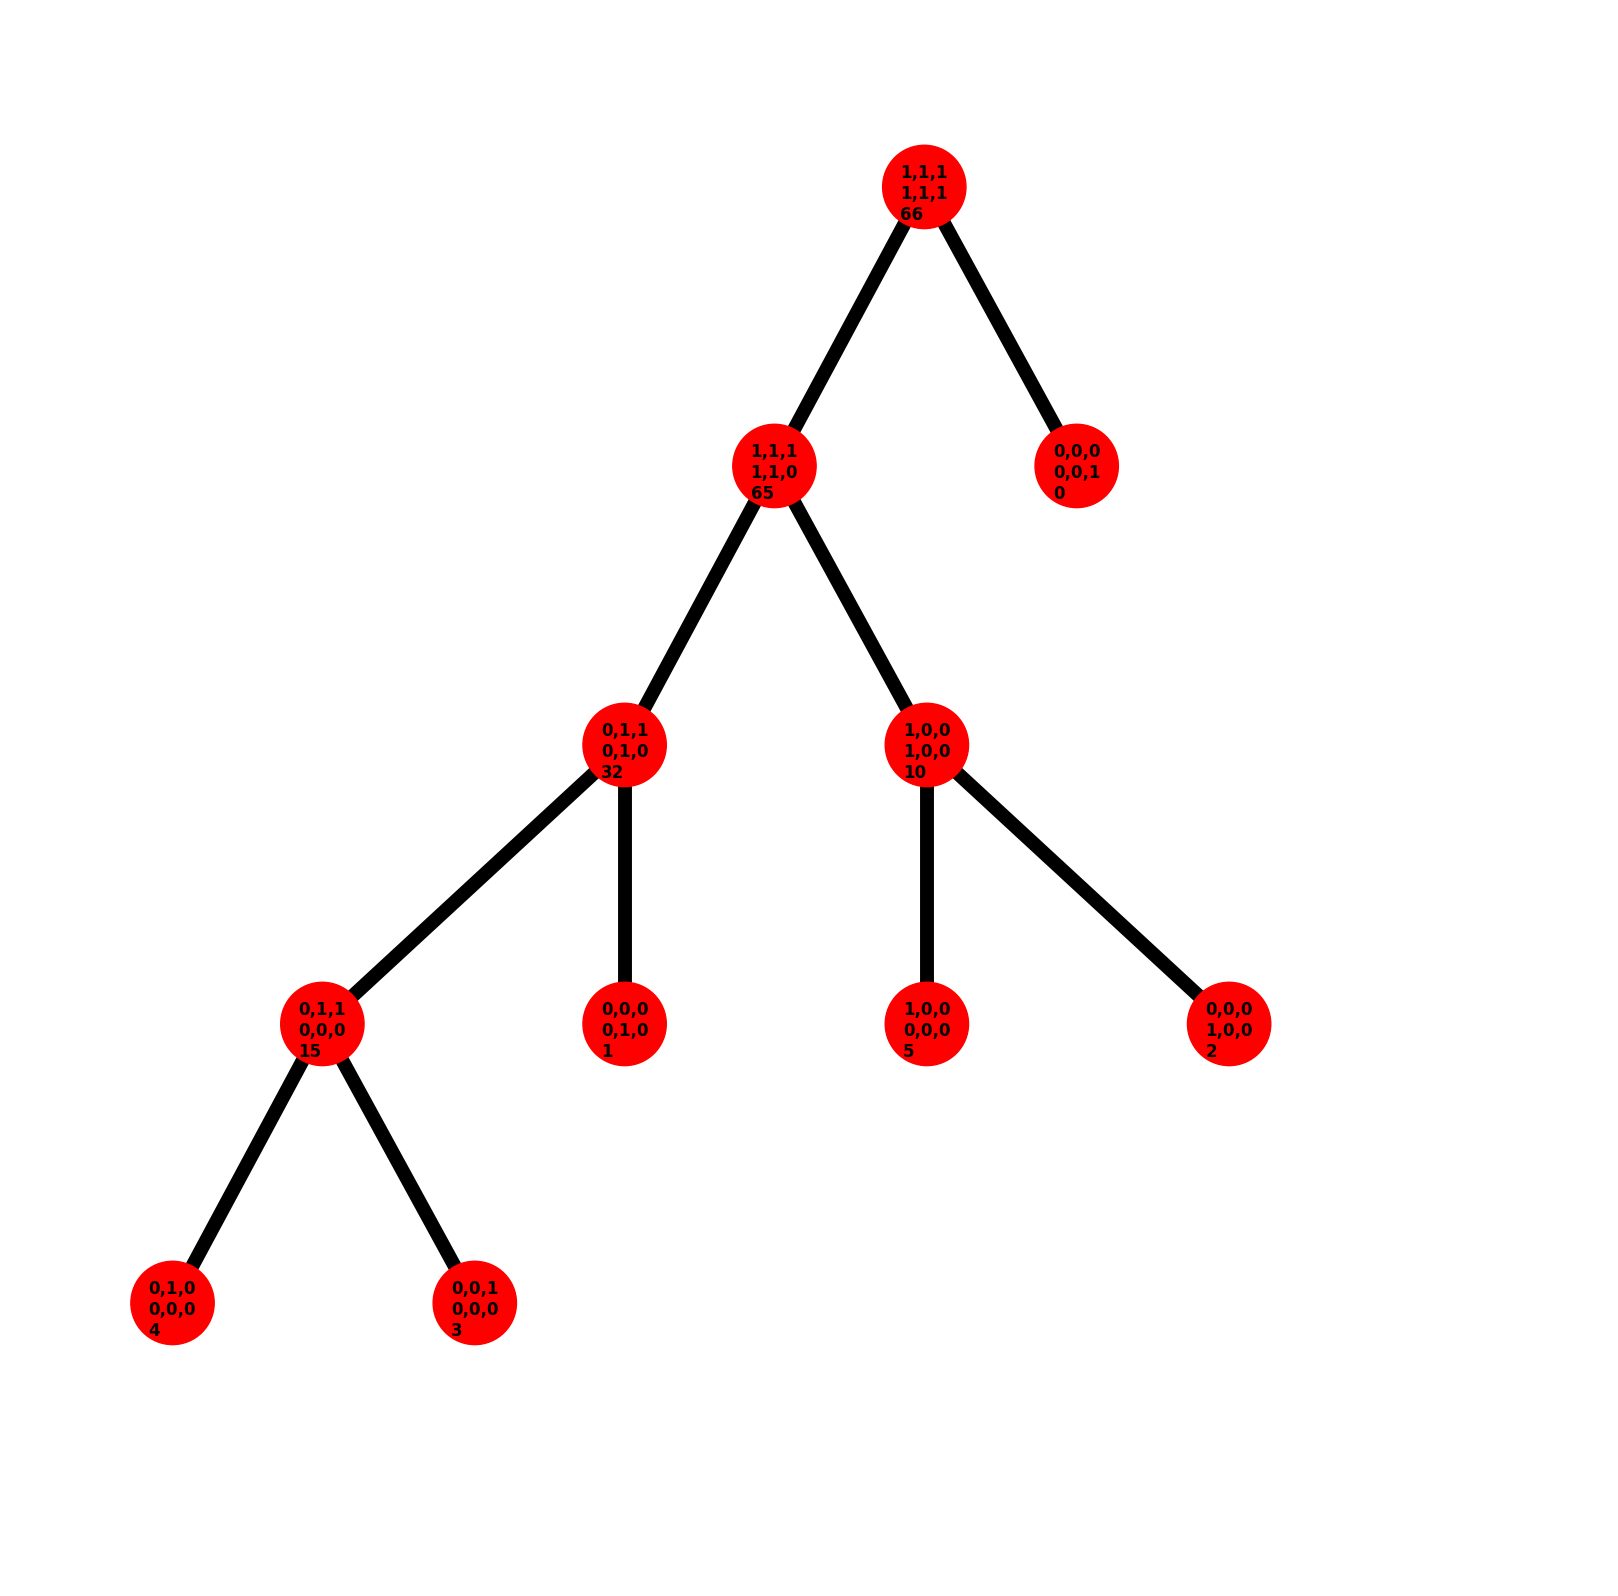

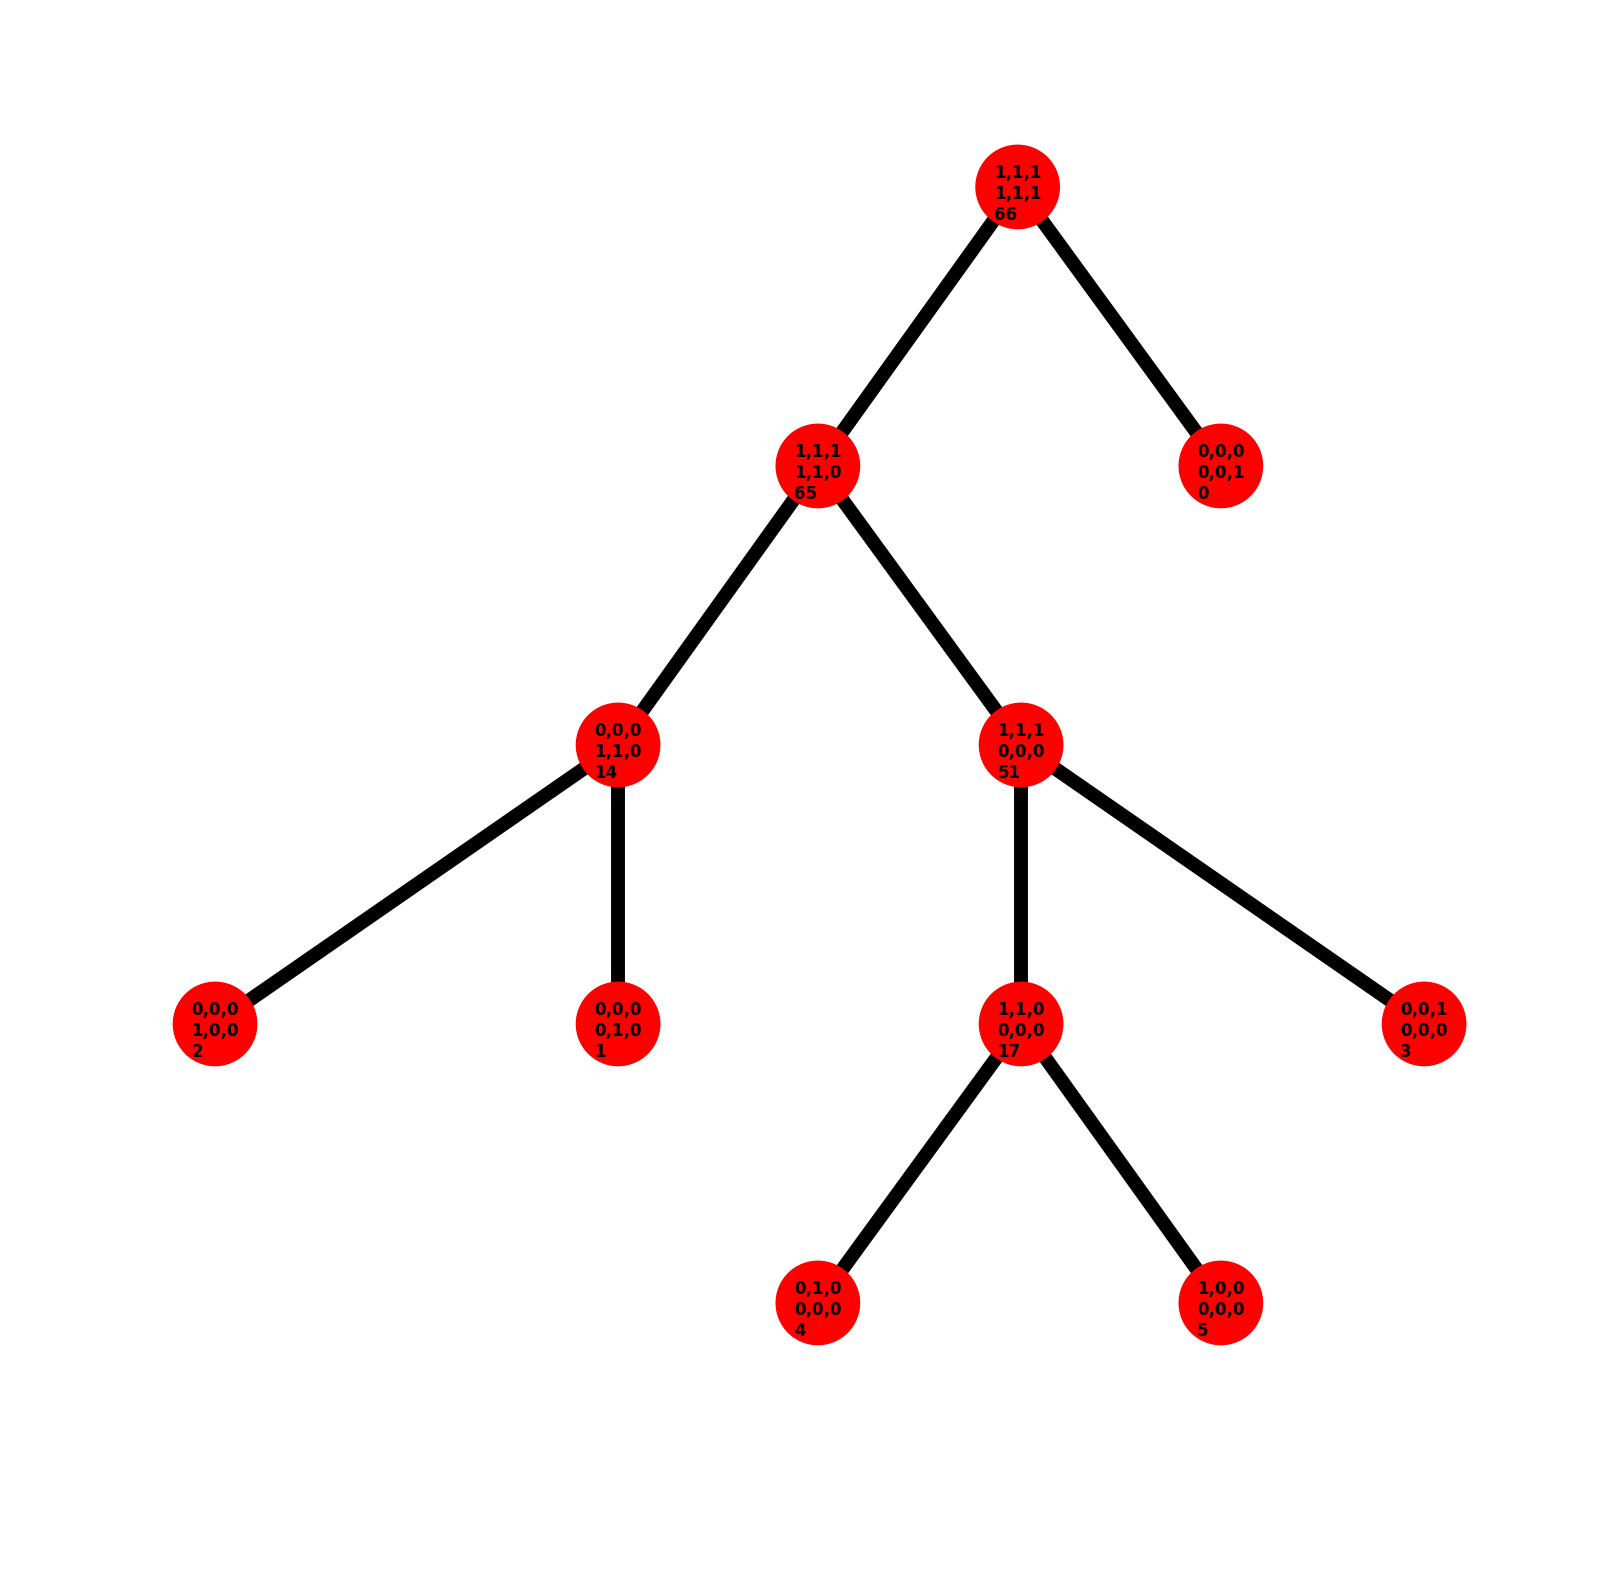

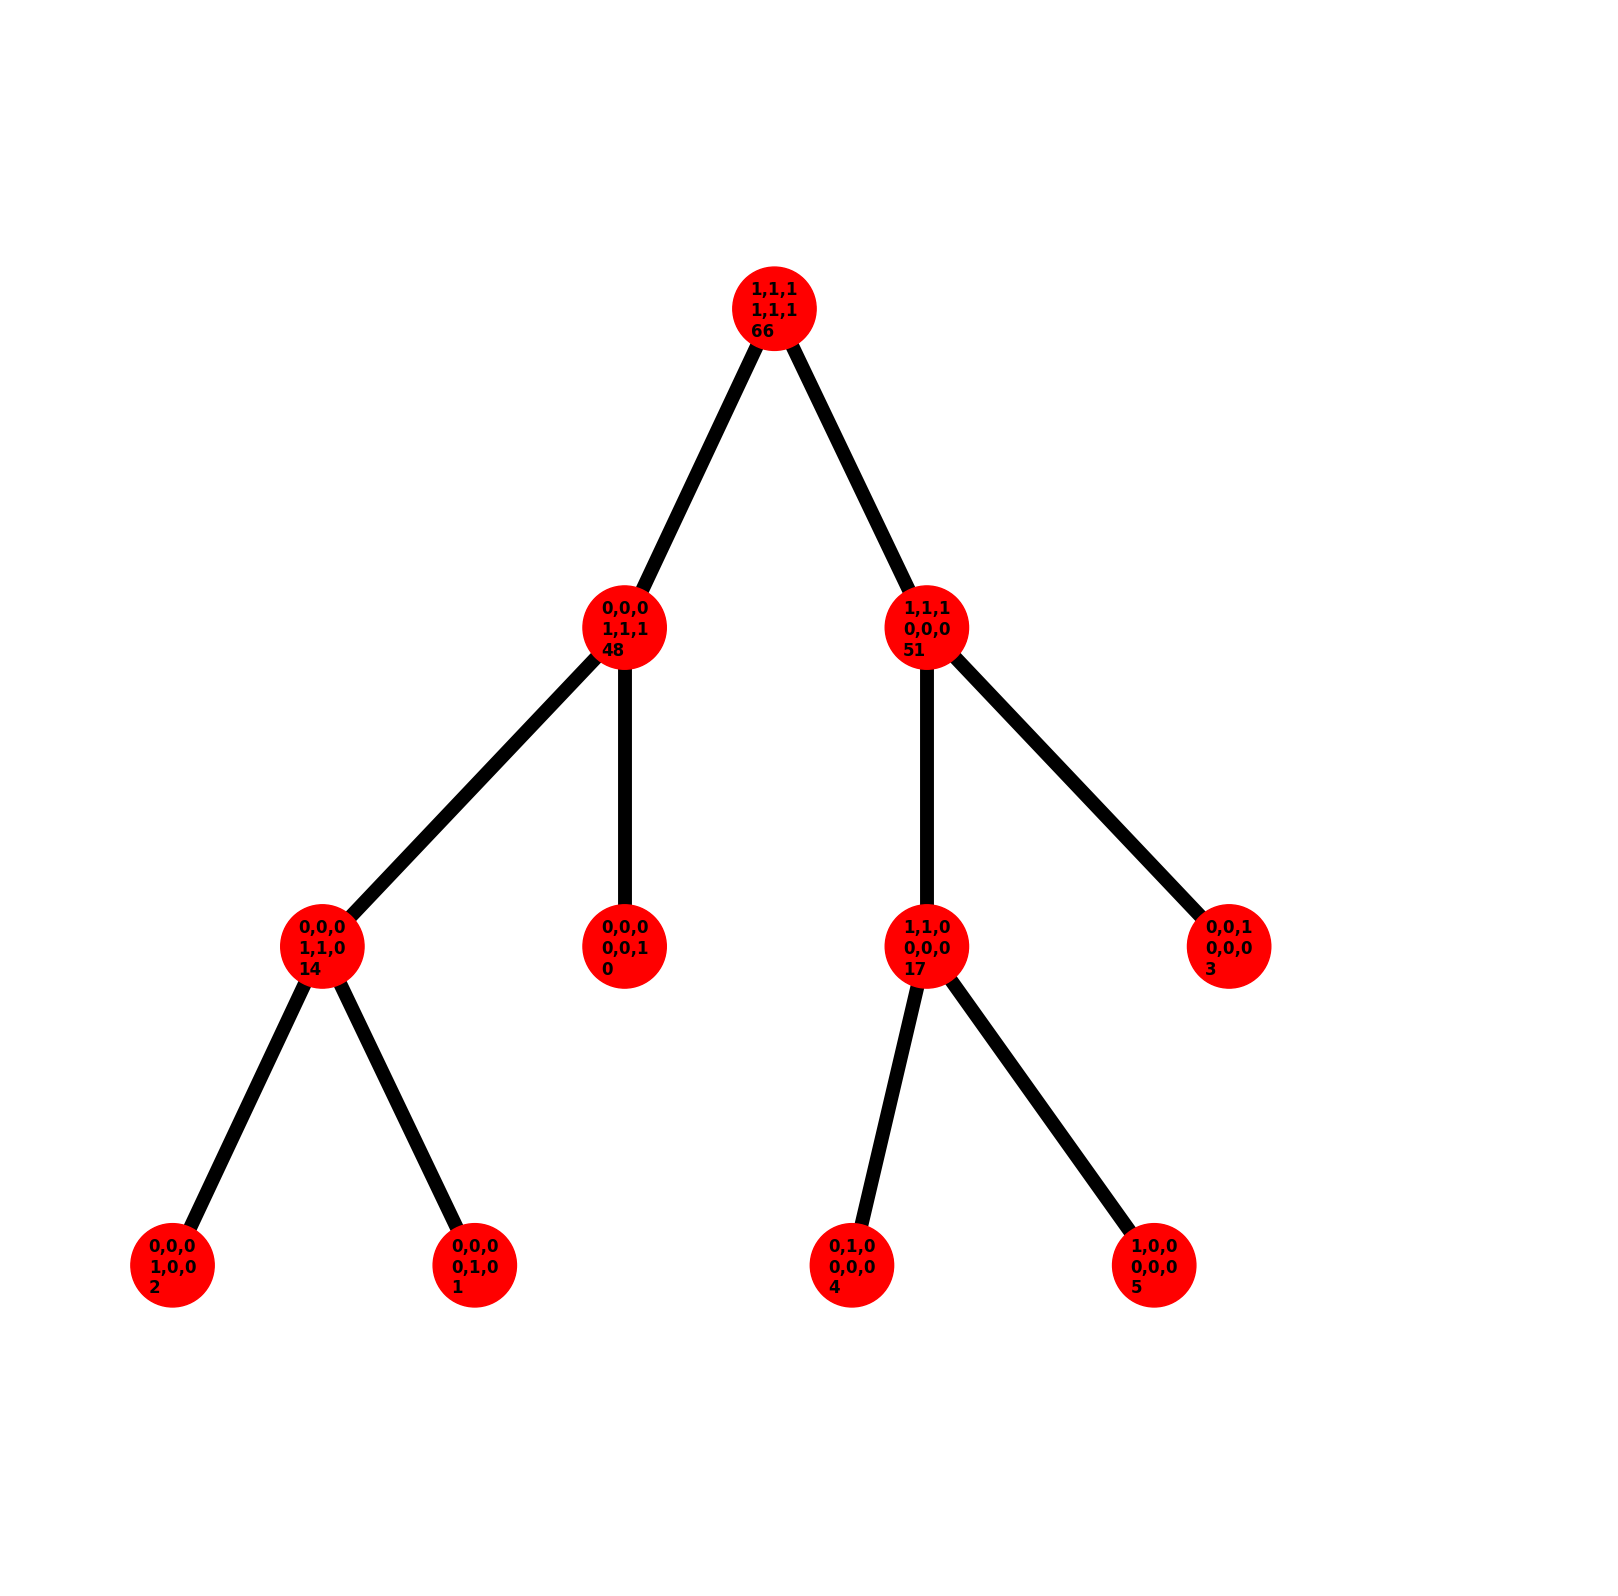

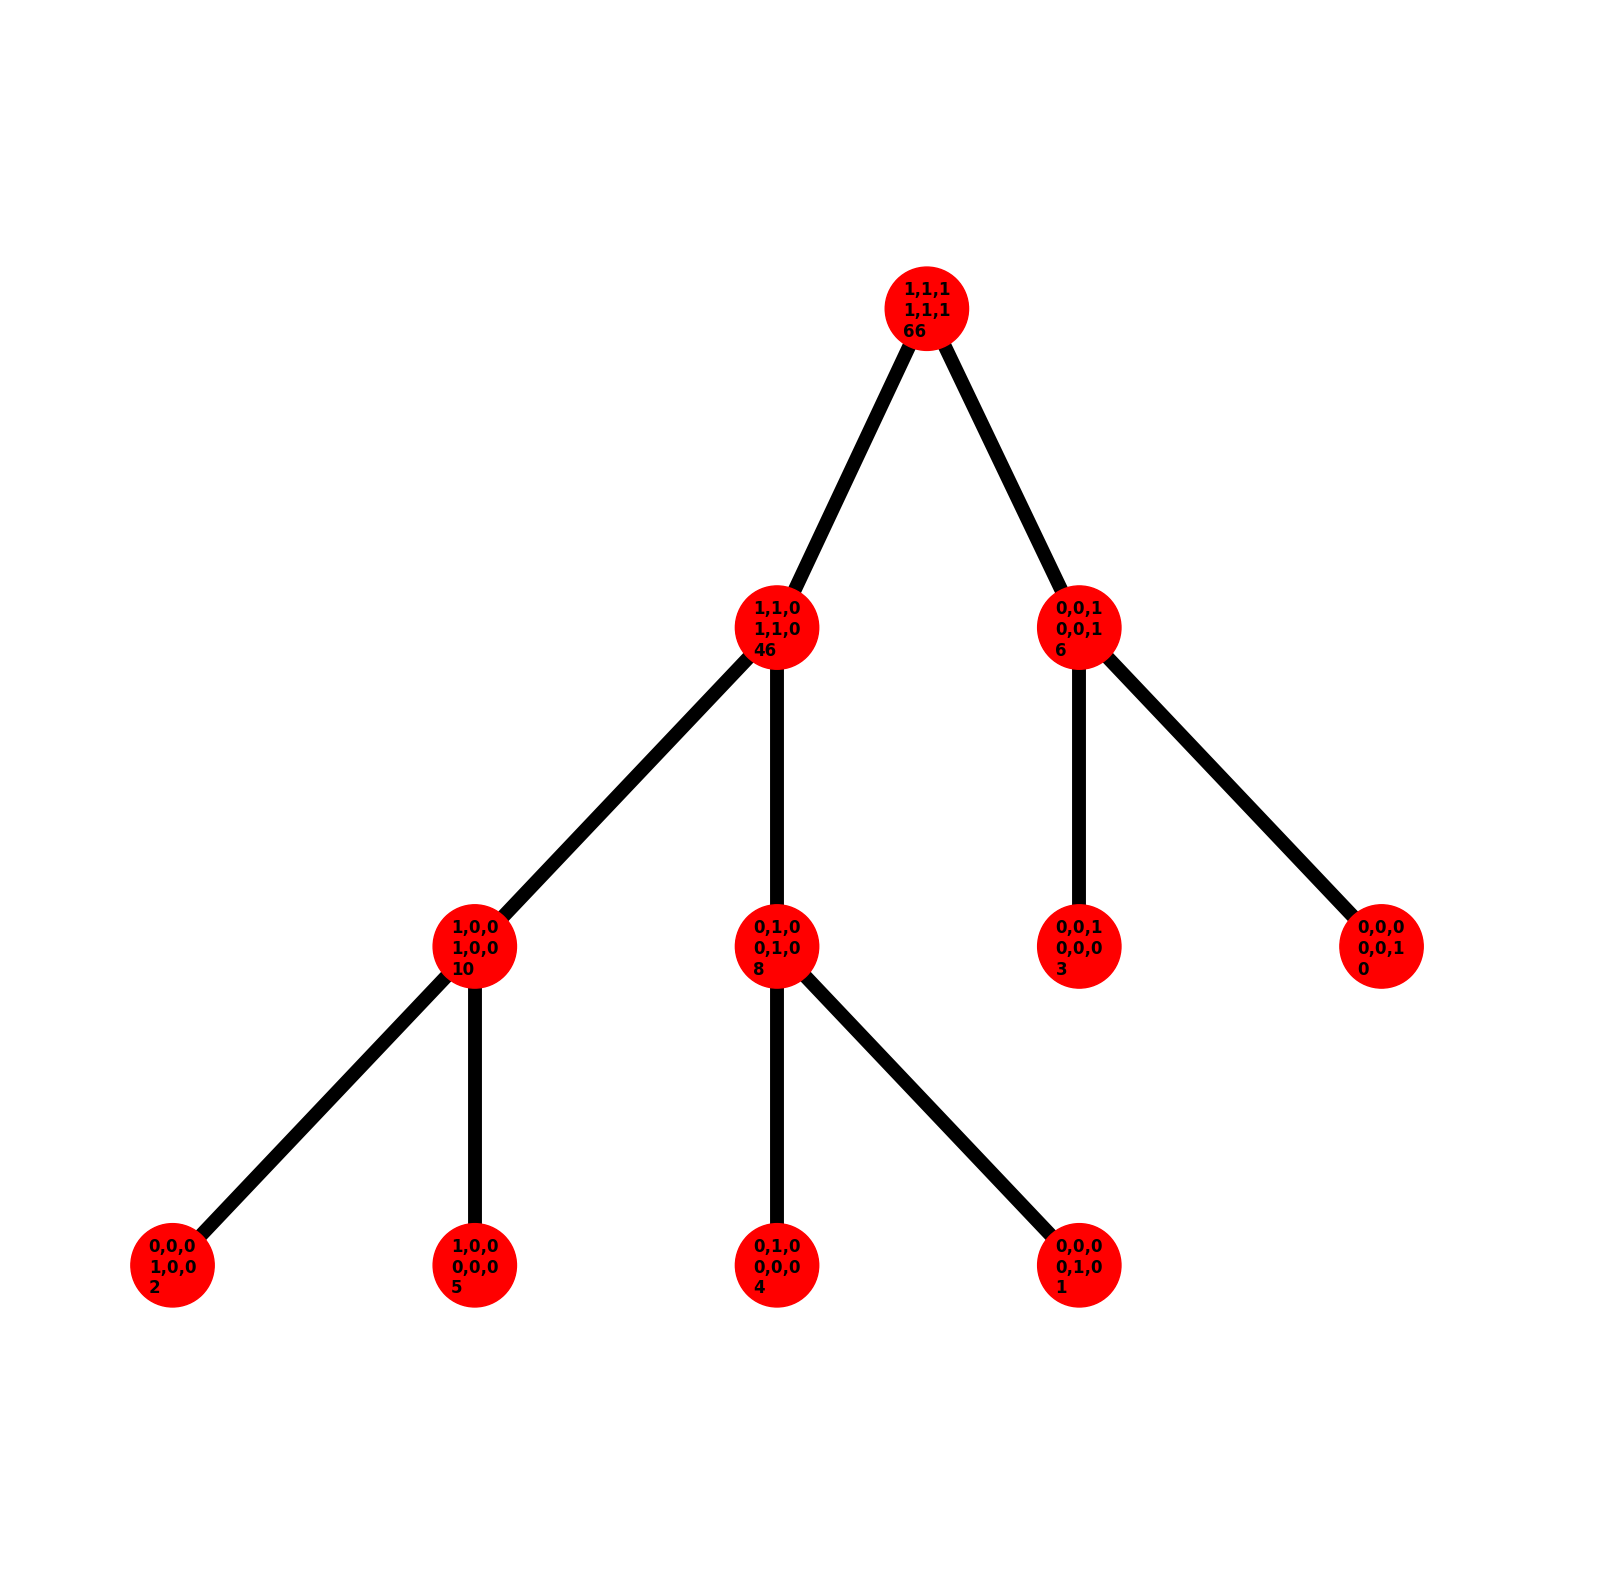

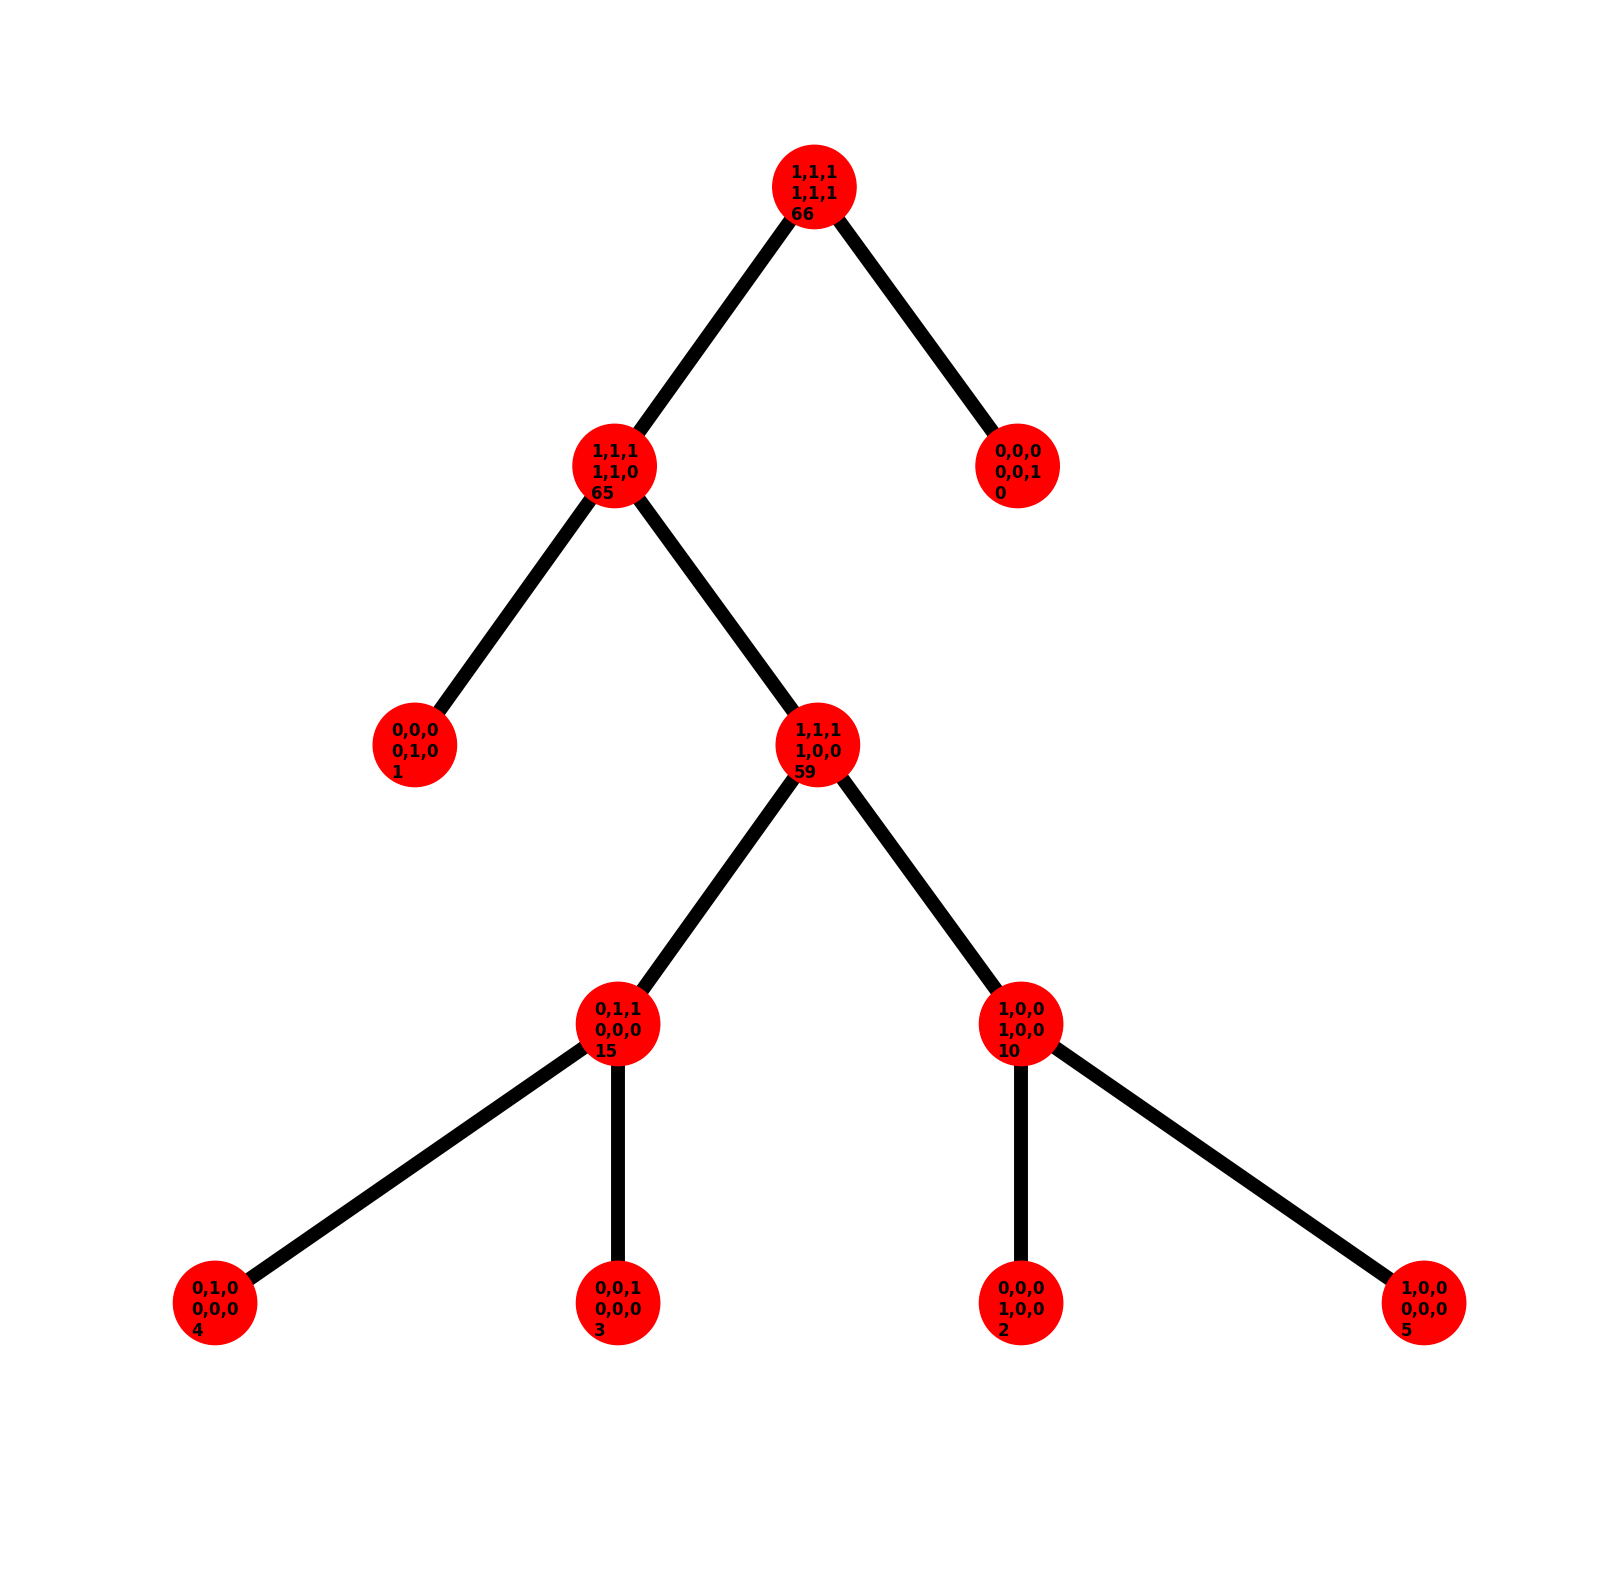

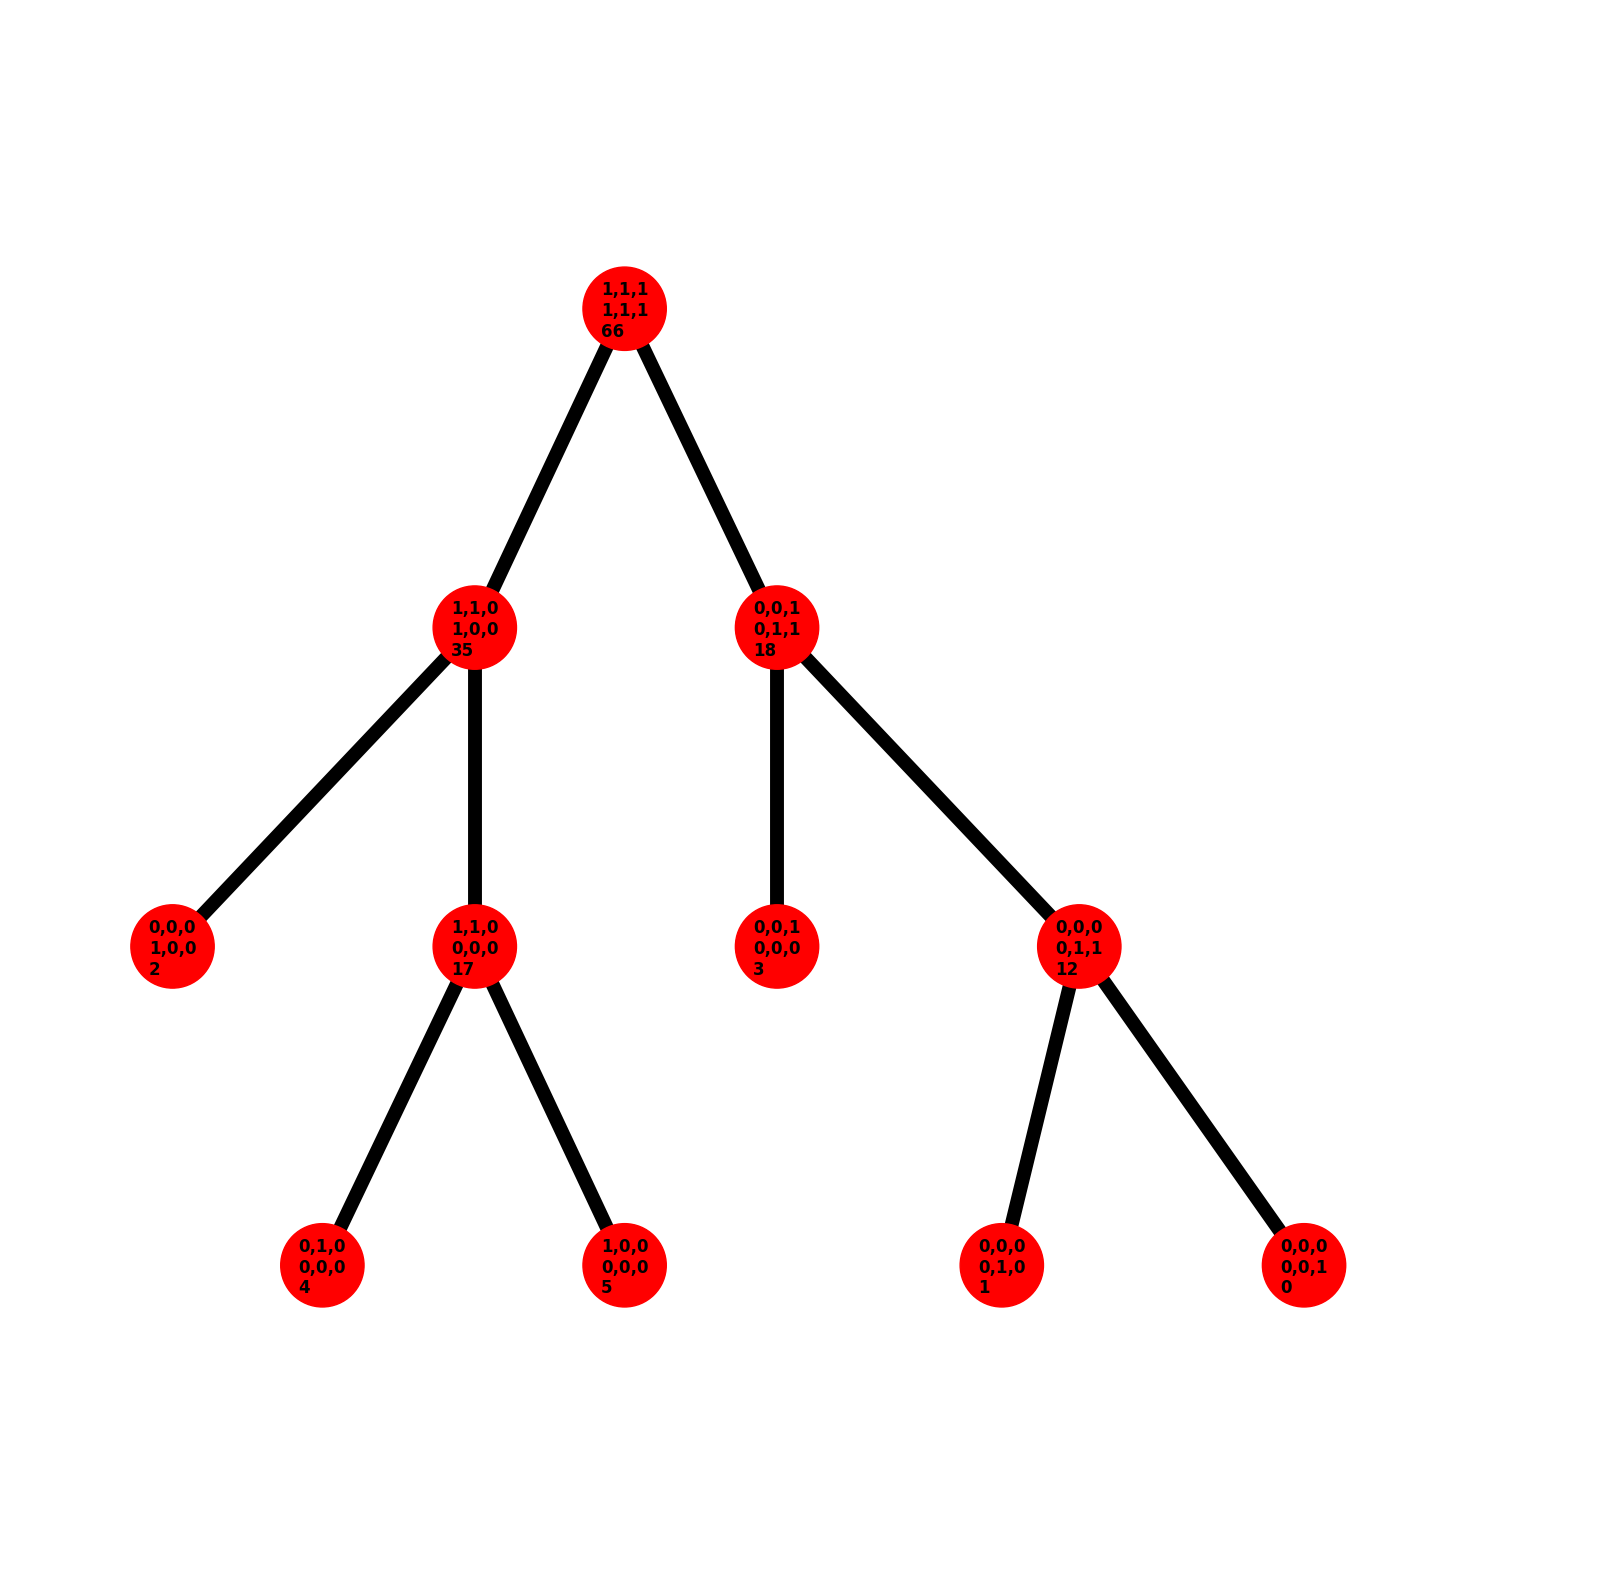

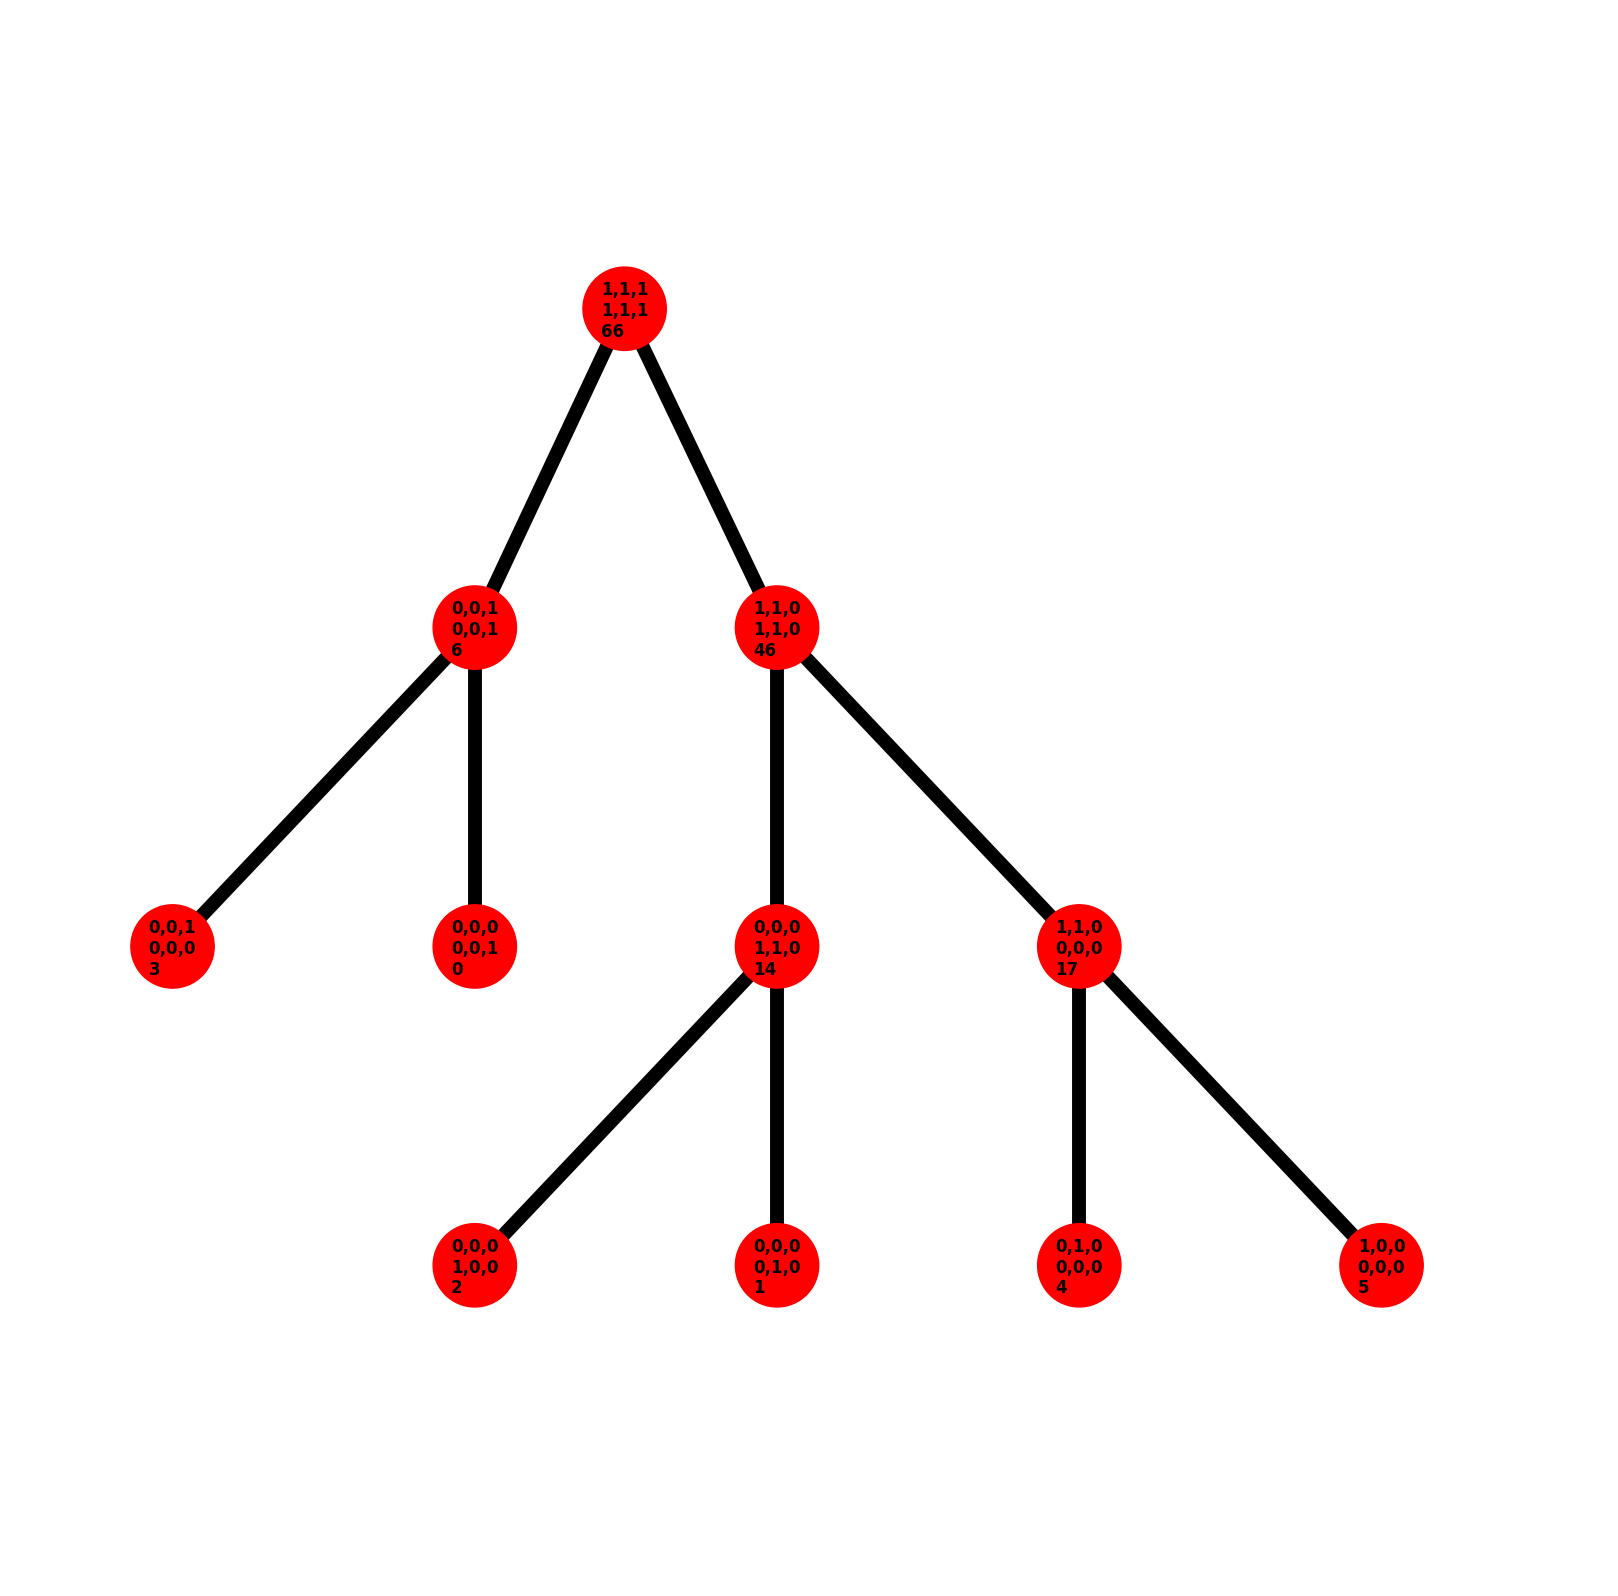

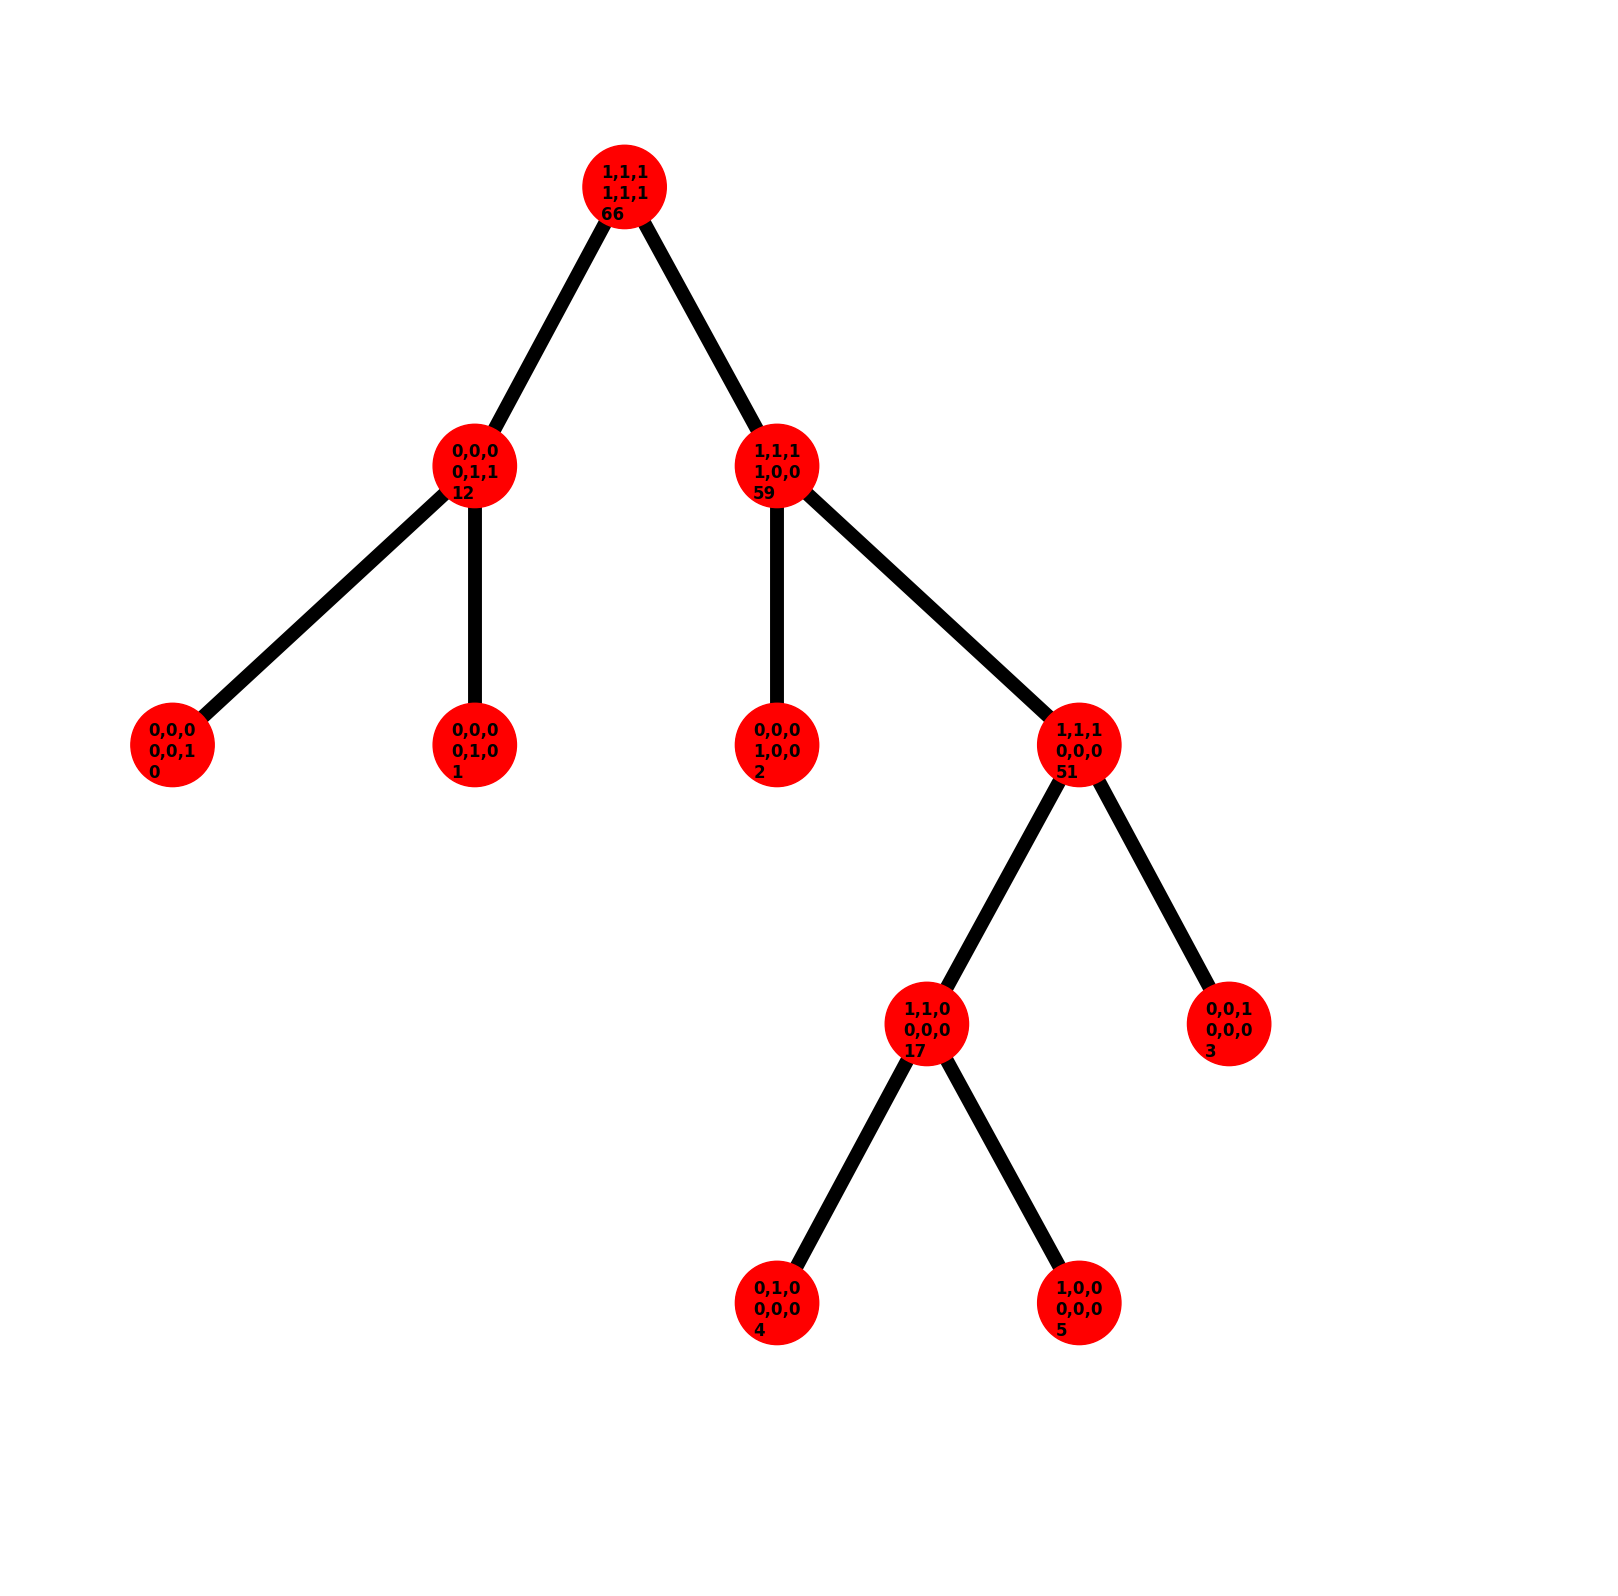

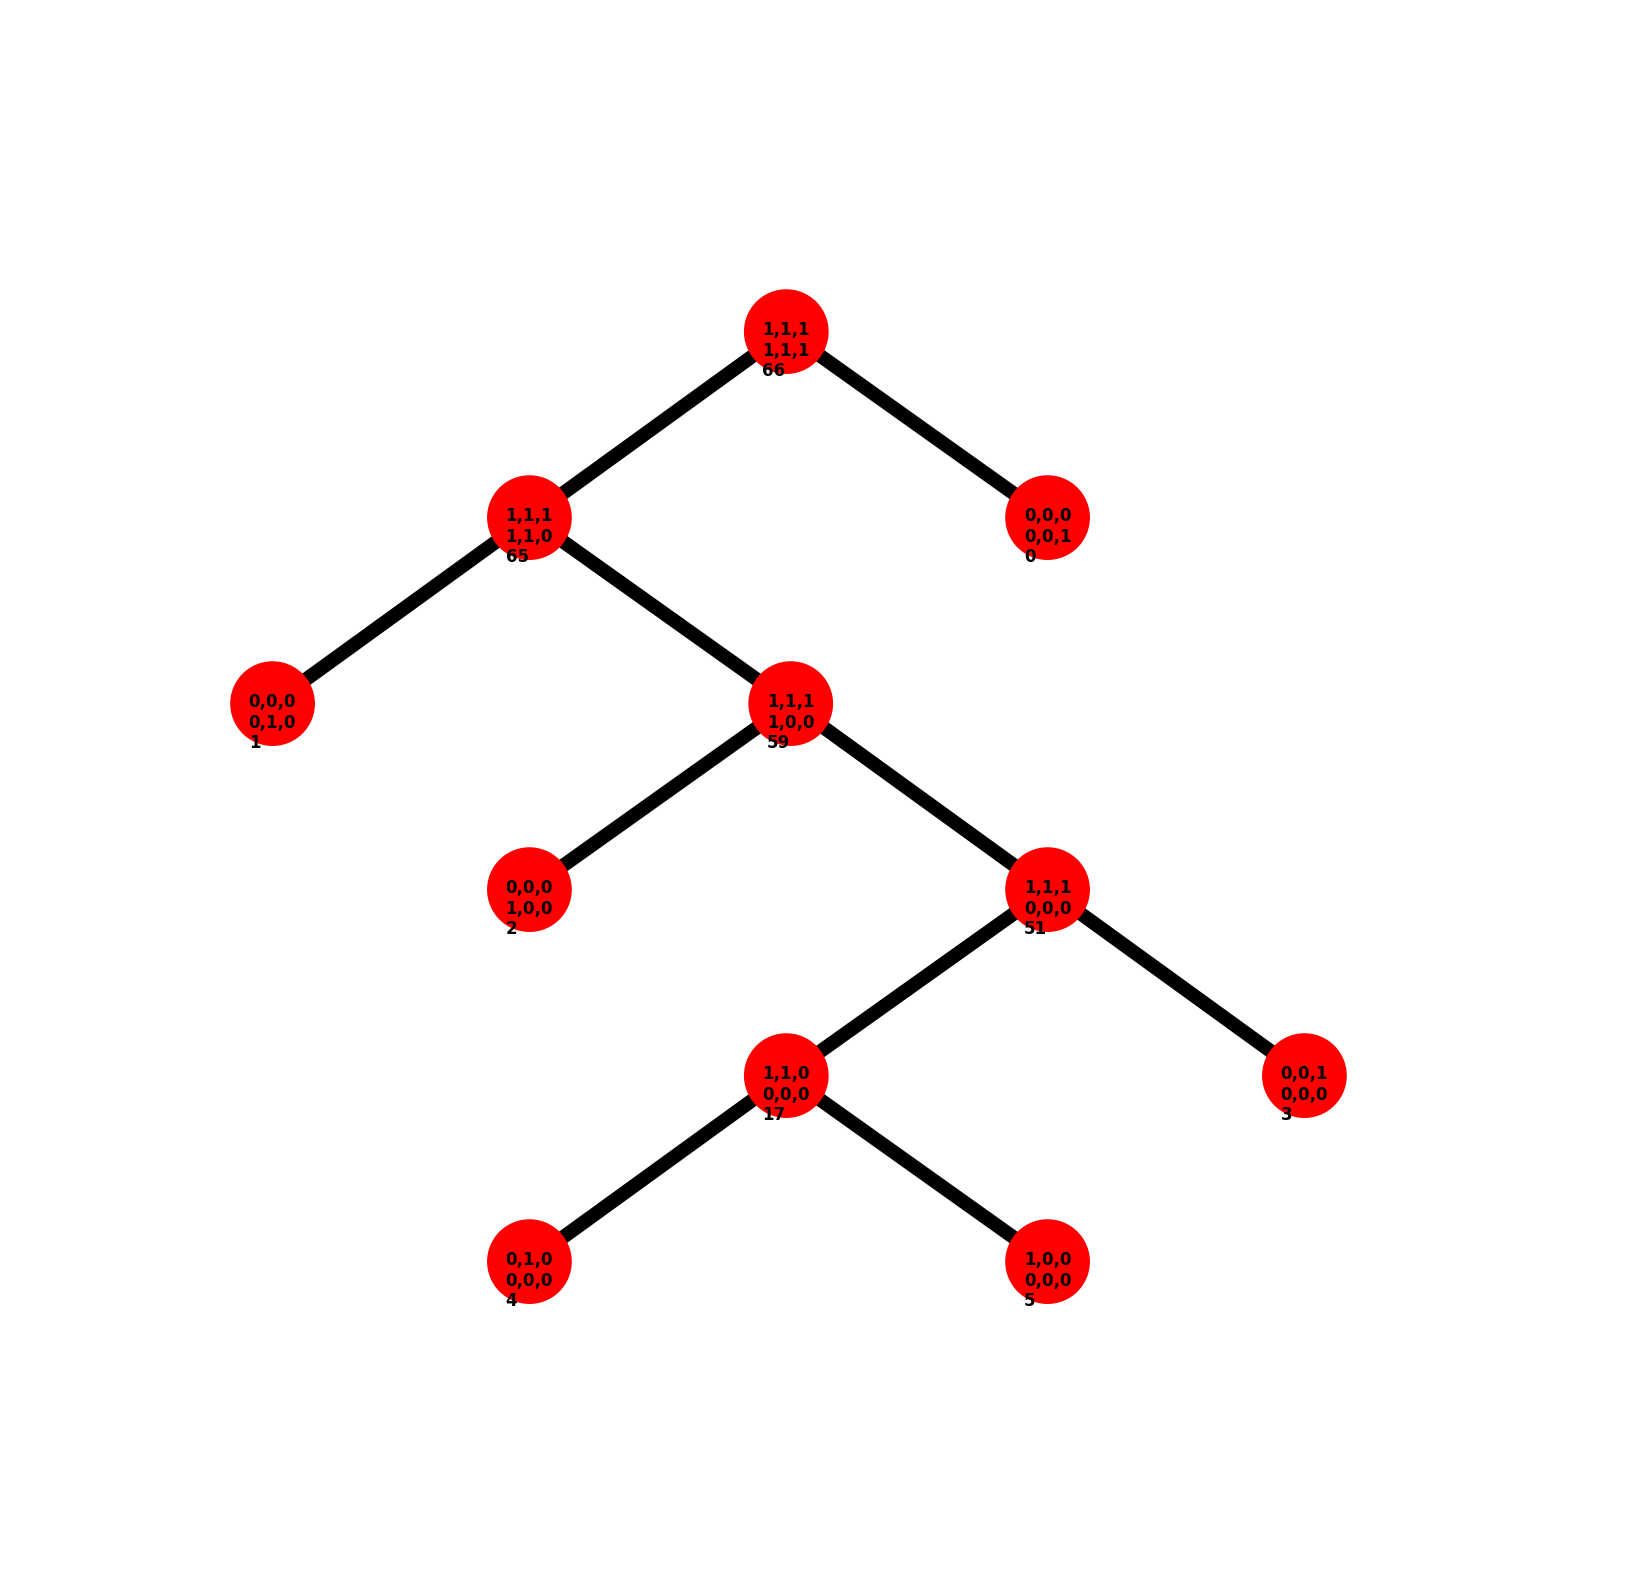

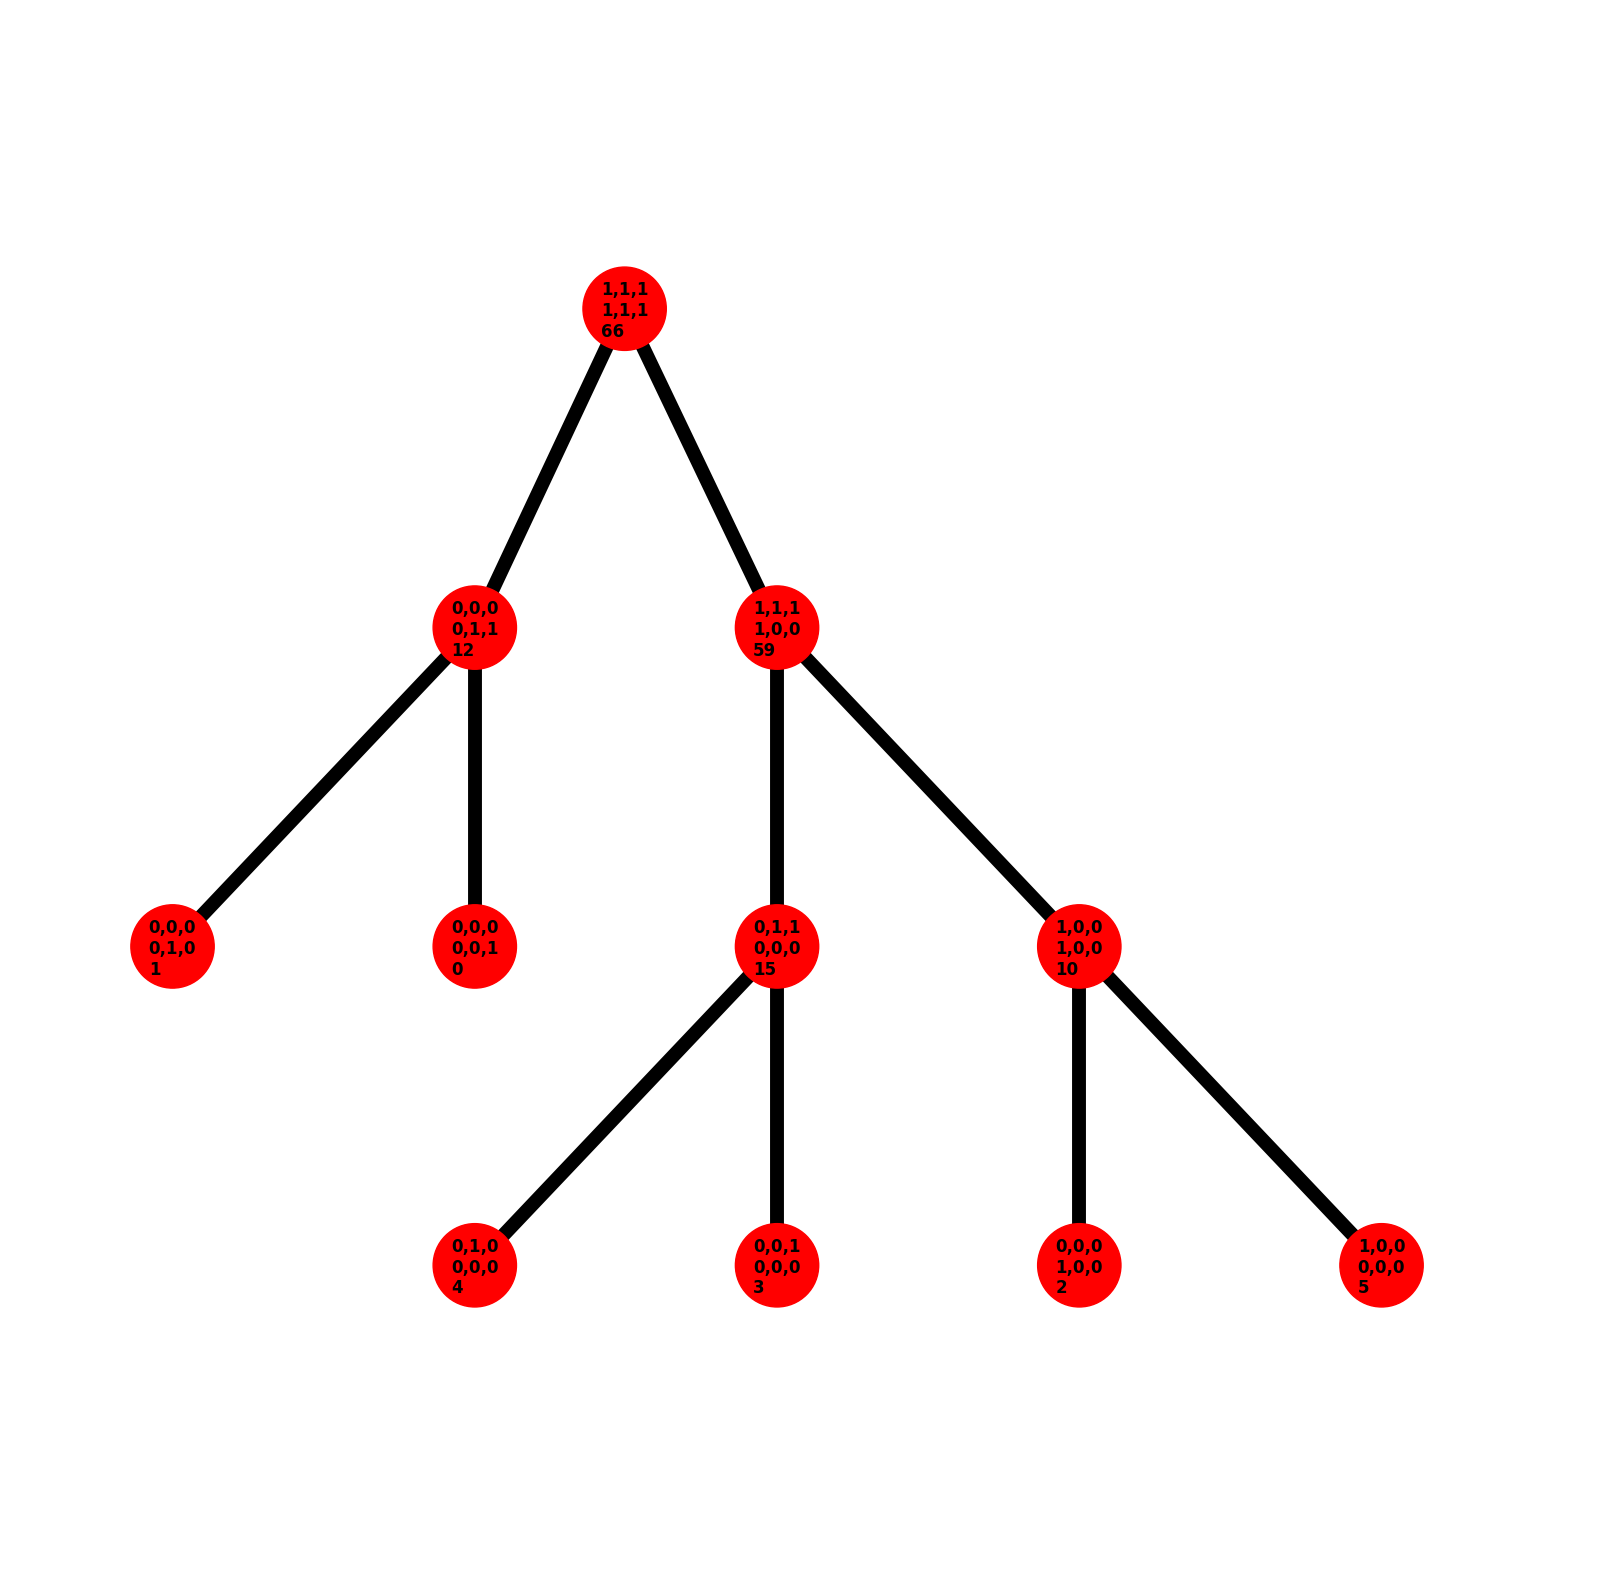

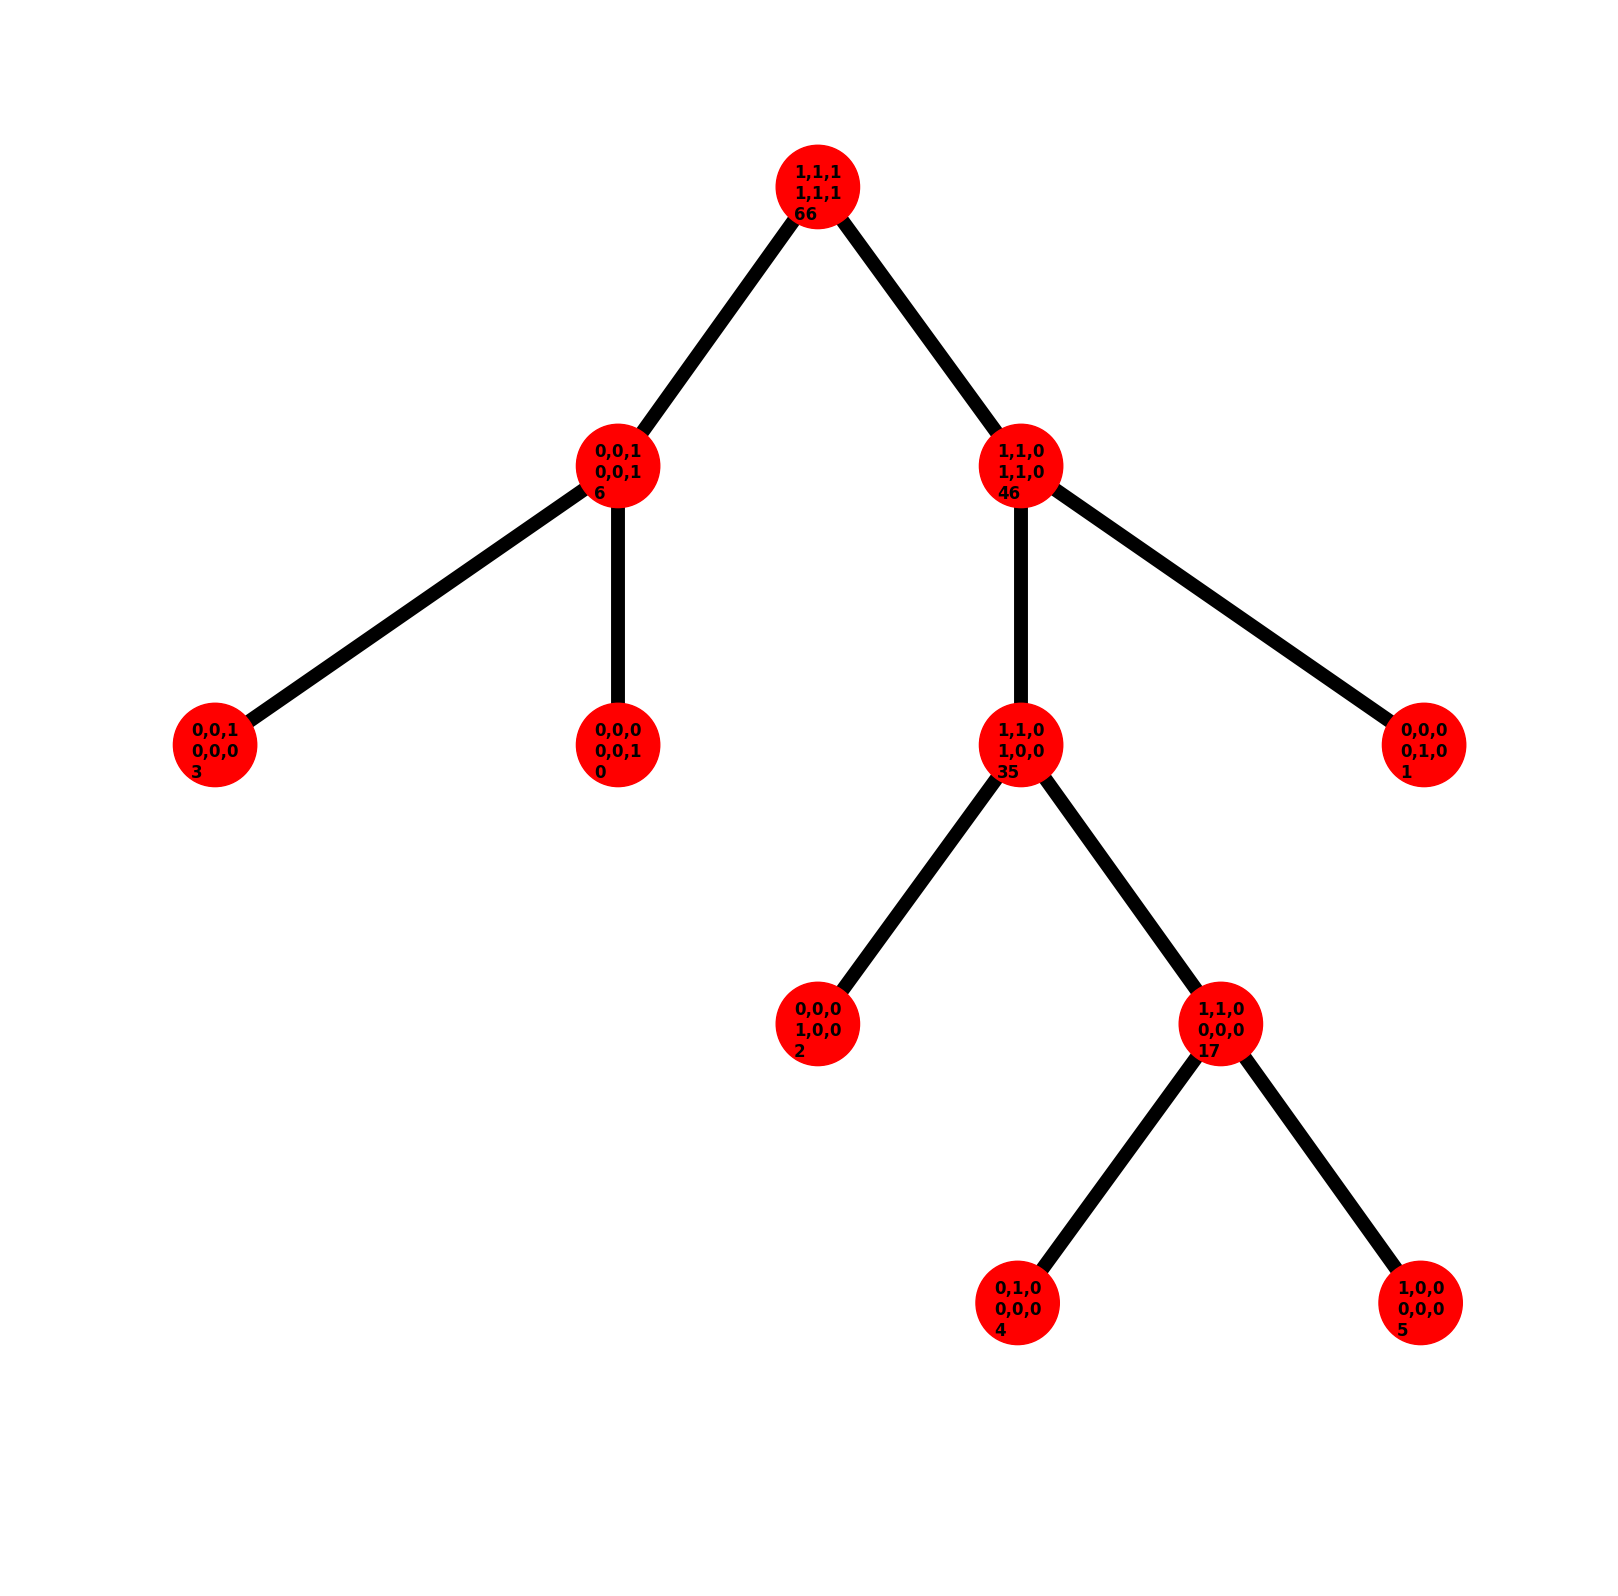

In [11]:
OutputGraphs = True
# print mpl.rcParams
# InvalidGraphs
print(len(SortedPathways.values()))
if OutputGraphs:
    for i, Key in enumerate(SortedPathways.values()[:]):
        F = Plot(
            Key,
            Show=True,
            pretty_images="text",
            Data=D
            )
        F.savefig("./Images/UniquePathway{}.pdf".format(i+1), 
                            bbox_inches = 'tight',
                            transparent=True,
                            #dpi = 2400
                            #dpi = 'figure'
                            )
        plt.close(F)
        del F

In [12]:
T = SortedPathways.values()[0]

In [13]:
T.nodes()

['1,1,1;1,1,1',
 '1,0,0;0,0,0',
 '0,1,0;0,0,0',
 '0,1,1;0,1,0',
 '1,0,0;1,0,0',
 '0,0,0;1,0,0',
 '0,1,1;0,0,0',
 '1,1,1;1,1,0',
 '0,0,0;0,1,0',
 '0,0,0;0,0,1',
 '0,0,1;0,0,0']

In [14]:
A = SpeciesToArrays(SpeciesToRepString(10))

In [15]:
SpeciesToRepString(A)

'0,0,1;0,1,0'

In [16]:
print type(A)==np.ndarray
print A
print A[::-1]
print np.roll(A, 1)
print SpeciesToRepString(A)
print SpeciesToRepString(A[::-1])

True
[[0 0 1]
 [0 1 0]]
[[0 1 0]
 [0 0 1]]
[[0 0 0]
 [1 0 1]]
0,0,1;0,1,0
0,1,0;0,0,1


In [17]:
SpeciesInt = 7
CurS = Symmetries(SpeciesInt, Unique=False)
print("---------------------")
for x in CurS:
    print("{:=4} : {}".format(SpeciesArrayToInt(x),x))
CurS = Symmetries(SpeciesInt, Unique=True)
print("---------------------")
for x in CurS:
    print("{:=4} : {}".format(SpeciesArrayToInt(x),x))    

---------------------
  56 : 1,1,1;0,0,0
  56 : 1,1,1;0,0,0
  56 : 1,1,1;0,0,0
   7 : 0,0,0;1,1,1
   7 : 0,0,0;1,1,1
   7 : 0,0,0;1,1,1
---------------------
  56 : 1,1,1;0,0,0
   7 : 0,0,0;1,1,1


In [18]:
SpeciesToRepString(6)

'0,0,0;1,1,0'

In [19]:
N = 3
print SpeciesToRepString(2**(2*N)-1)
print SpeciesToRepString(2**(2*N-1))
SpeciesToRepString(2**(2*N-1))

1,1,1;1,1,1
1,0,0;0,0,0


'1,0,0;0,0,0'

In [20]:
T = InvalidGraphs.items()[0]

In [21]:
SortedPathways[T[0]]

In [22]:
range(1,N)

[1, 2]

In [23]:
T

(frozenset({'0,0,0;0,0,1',
            '0,0,0;0,1,0',
            '0,0,0;1,0,0',
            '0,0,1;0,0,0',
            '0,1,0;0,0,0',
            '0,1,1;0,0,0',
            '0,1,1;0,1,0',
            '1,0,0;0,0,0',
            '1,0,0;1,0,0',
            '1,1,1;1,1,0',
            '1,1,1;1,1,1'}),
  <networkx.classes.digraph.DiGraph at 0x7fee19c5c150>])

In [24]:
Symmetries(31, Unique=False)

['1,1,1;1,1,0',
 '1,1,1;1,0,1',
 '1,1,1;0,1,1',
 '1,1,0;1,1,1',
 '1,0,1;1,1,1',
 '0,1,1;1,1,1']

In [25]:
D.Species.keys()

[32, 36, 48, 50, 51, 52, 53, 54, 56, 60, 62, 63]

In [26]:
np.array([Symmetries(D.Species.keys()[x], Ints=True, Unique=False) for x in range(len(D.Species.keys()))]).flatten()
D.SpeciesNumbers

[1,
 2,
 4,
 8,
 16,
 32,
 9,
 9,
 18,
 18,
 36,
 36,
 3,
 5,
 6,
 24,
 40,
 48,
 11,
 22,
 25,
 37,
 44,
 50,
 29,
 30,
 43,
 46,
 51,
 53,
 13,
 19,
 26,
 38,
 41,
 52,
 29,
 30,
 43,
 46,
 51,
 53,
 27,
 27,
 45,
 45,
 54,
 54,
 7,
 7,
 7,
 56,
 56,
 56,
 15,
 23,
 39,
 57,
 58,
 60,
 31,
 47,
 55,
 59,
 61,
 62,
 63,
 63,
 63,
 63,
 63,
 63]

In [27]:
[SpeciesToRepString(x) for x in D.SpeciesNumbers]

['0,0,0;0,0,1',
 '0,0,0;0,1,0',
 '0,0,0;1,0,0',
 '0,0,1;0,0,0',
 '0,1,0;0,0,0',
 '1,0,0;0,0,0',
 '0,0,1;0,0,1',
 '0,0,1;0,0,1',
 '0,1,0;0,1,0',
 '0,1,0;0,1,0',
 '1,0,0;1,0,0',
 '1,0,0;1,0,0',
 '0,0,0;0,1,1',
 '0,0,0;1,0,1',
 '0,0,0;1,1,0',
 '0,1,1;0,0,0',
 '1,0,1;0,0,0',
 '1,1,0;0,0,0',
 '0,0,1;0,1,1',
 '0,1,0;1,1,0',
 '0,1,1;0,0,1',
 '1,0,0;1,0,1',
 '1,0,1;1,0,0',
 '1,1,0;0,1,0',
 '0,1,1;1,0,1',
 '0,1,1;1,1,0',
 '1,0,1;0,1,1',
 '1,0,1;1,1,0',
 '1,1,0;0,1,1',
 '1,1,0;1,0,1',
 '0,0,1;1,0,1',
 '0,1,0;0,1,1',
 '0,1,1;0,1,0',
 '1,0,0;1,1,0',
 '1,0,1;0,0,1',
 '1,1,0;1,0,0',
 '0,1,1;1,0,1',
 '0,1,1;1,1,0',
 '1,0,1;0,1,1',
 '1,0,1;1,1,0',
 '1,1,0;0,1,1',
 '1,1,0;1,0,1',
 '0,1,1;0,1,1',
 '0,1,1;0,1,1',
 '1,0,1;1,0,1',
 '1,0,1;1,0,1',
 '1,1,0;1,1,0',
 '1,1,0;1,1,0',
 '0,0,0;1,1,1',
 '0,0,0;1,1,1',
 '0,0,0;1,1,1',
 '1,1,1;0,0,0',
 '1,1,1;0,0,0',
 '1,1,1;0,0,0',
 '0,0,1;1,1,1',
 '0,1,0;1,1,1',
 '1,0,0;1,1,1',
 '1,1,1;0,0,1',
 '1,1,1;0,1,0',
 '1,1,1;1,0,0',
 '0,1,1;1,1,1',
 '1,0,1;1,1,1',
 '1,1,0;

In [28]:
D.SpeciesNumberLookup(54)

46

In [29]:
SpeciesToRepString(63)


'1,1,1;1,1,1'

In [30]:
T = D.Reactions[0]
D.ReactionRelations(T)

(36, 32, 32)

In [31]:
# [[map(D.SpeciesNumberLookup, k) for k in Symmetries(36, Unique=True, Ints=True)]]

for Rec in D.Reactions:
    Rs = D.ReactionRelations(Rec)
    print Rs
    for Sym in [Symmetries(R, Unique=False, Ints=True) for R in Rs]:
        print Sym
        
    
    #print [SpeciesToRepString(x) for x in map(D.SpeciesNumberLookup, D.ReactionRelations(Rec))]
    

(36, 32, 32)
[36, 36, 18, 18, 9, 9]
[32, 16, 8, 4, 2, 1]
[32, 16, 8, 4, 2, 1]
(48, 32, 32)
[48, 40, 24, 6, 5, 3]
[32, 16, 8, 4, 2, 1]
[32, 16, 8, 4, 2, 1]
(50, 32, 36)
[50, 44, 37, 25, 22, 11]
[32, 16, 8, 4, 2, 1]
[36, 36, 18, 18, 9, 9]
(50, 32, 48)
[50, 44, 37, 25, 22, 11]
[32, 16, 8, 4, 2, 1]
[48, 40, 24, 6, 5, 3]
(51, 32, 50)
[53, 51, 46, 43, 30, 29]
[32, 16, 8, 4, 2, 1]
[50, 44, 37, 25, 22, 11]
(51, 48, 48)
[53, 51, 46, 43, 30, 29]
[48, 40, 24, 6, 5, 3]
[48, 40, 24, 6, 5, 3]
(52, 32, 36)
[52, 41, 38, 26, 19, 13]
[32, 16, 8, 4, 2, 1]
[36, 36, 18, 18, 9, 9]
(52, 32, 48)
[52, 41, 38, 26, 19, 13]
[32, 16, 8, 4, 2, 1]
[48, 40, 24, 6, 5, 3]
(53, 32, 52)
[53, 51, 46, 43, 30, 29]
[32, 16, 8, 4, 2, 1]
[52, 41, 38, 26, 19, 13]
(53, 48, 48)
[53, 51, 46, 43, 30, 29]
[48, 40, 24, 6, 5, 3]
[48, 40, 24, 6, 5, 3]
(54, 32, 50)
[54, 54, 45, 45, 27, 27]
[32, 16, 8, 4, 2, 1]
[50, 44, 37, 25, 22, 11]
(54, 32, 52)
[54, 54, 45, 45, 27, 27]
[32, 16, 8, 4, 2, 1]
[52, 41, 38, 26, 19, 13]
(54, 36, 36)
[54, 5

In [32]:
D.SpeciesNumberLookup(7)

48

In [33]:
D.Children(39,40)

(3, 36, 39)

In [34]:

SpeciesToArrays(7) + SpeciesToArrays(56)

array([[1, 1, 1],
       [1, 1, 1]], dtype=int8)

In [35]:
D.Children(39,32)

(7, 32, 39)

In [36]:
np.sum(D.SpeciesNumbers == SpeciesArrayToInt(D.Children(39,32)[2]))

0

In [37]:
SpeciesArrayToInt(D.Children(39,32)[2])

39

In [38]:
SpeciesArrayToInt(SpeciesToArrays(7))

7

In [39]:
D.FindReactions(32)

[]

In [40]:
np.array(D.Reactions)[:,3]

array([ 1,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  7,  7,  8,  9,  9,
        9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11])

In [41]:
[D.SpeciesConvert[x[3]] for x in D.Reactions]

KeyError: 1

In [ ]:
(SpeciesToArrays(15)[0] + SpeciesToArrays(15)[1] != 2).all()

In [123]:
import inspect
def PrintIter(ob):
    frame = inspect.currentframe()
    frame = inspect.getouterframes(frame)[1]
    string = inspect.getframeinfo(frame[0]).code_context[0].strip()
    arg = string[string.find('(') + 1:-1].split(',')[0]
#     print arg
#     print "{} : {}".format([ k for k,v in locals().iteritems() if (v == ob and not k == 'ob')][0], type(ob))
    print "{} : {}\n".format(arg, type(ob))
    if type(ob) == OrderedDict or type(ob) == dict:
        for x, y in ob.items():
            print "{: >2} : {}".format(x, y)
    if (type(ob) == list or type(ob) == np.ndarray) and not arg=="D.Reactions":
        for x, y in enumerate(ob):
            print "{: >2} : {}".format(x, y)
    if arg=="D.Reactions":
#         print "Converted to Species Int:"
        for x, y in enumerate(ob):
            print "{: >3} : {: >2}, {: >2} -> {: >2} : {}".format(x, D.ReactionRelations(y)[0],D.ReactionRelations(y)[1],D.ReactionRelations(y)[2], y)


In [124]:
PrintIter(D.SpeciesConvert)

D.SpeciesConvert : <class 'collections.OrderedDict'>

32 : 0
36 : 1
48 : 2
50 : 3
51 : 4
52 : 5
53 : 6
54 : 7
56 : 8
60 : 9
62 : 10
63 : 11


In [125]:
PrintIter(D.SpeciesNumbers)

D.SpeciesNumbers : <type 'list'>

 0 : 1
 1 : 2
 2 : 4
 3 : 8
 4 : 16
 5 : 32
 6 : 9
 7 : 9
 8 : 18
 9 : 18
10 : 36
11 : 36
12 : 3
13 : 5
14 : 6
15 : 24
16 : 40
17 : 48
18 : 11
19 : 22
20 : 25
21 : 37
22 : 44
23 : 50
24 : 29
25 : 30
26 : 43
27 : 46
28 : 51
29 : 53
30 : 13
31 : 19
32 : 26
33 : 38
34 : 41
35 : 52
36 : 29
37 : 30
38 : 43
39 : 46
40 : 51
41 : 53
42 : 27
43 : 27
44 : 45
45 : 45
46 : 54
47 : 54
48 : 7
49 : 7
50 : 7
51 : 56
52 : 56
53 : 56
54 : 15
55 : 23
56 : 39
57 : 57
58 : 58
59 : 60
60 : 31
61 : 47
62 : 55
63 : 59
64 : 61
65 : 62
66 : 63
67 : 63
68 : 63
69 : 63
70 : 63
71 : 63


In [126]:
PrintIter(D.Reactions)

D.Reactions : <type 'list'>

  0 : 36, 32 -> 32 : [0, 0, 1, 1, 0, 1, 1]
  1 : 48, 32 -> 32 : [0, 0, 2, 2, 1, 0, 1]
  2 : 50, 32 -> 36 : [0, 1, 2, 3, 1, 0, 1]
  3 : 50, 32 -> 48 : [0, 2, 1, 3, 0, 1, 1]
  4 : 51, 32 -> 50 : [0, 3, 1, 4, 1, 0, 2]
  5 : 51, 48 -> 48 : [2, 2, 1, 4, 0, 1, 1]
  6 : 52, 32 -> 36 : [0, 1, 2, 5, 1, 0, 1]
  7 : 52, 32 -> 48 : [0, 2, 1, 5, 0, 1, 1]
  8 : 53, 32 -> 52 : [0, 5, 1, 6, 1, 0, 2]
  9 : 53, 48 -> 48 : [2, 2, 1, 6, 0, 1, 1]
 10 : 54, 32 -> 50 : [0, 3, 1, 7, 1, 1, 2]
 11 : 54, 32 -> 52 : [0, 5, 1, 7, 1, 1, 2]
 12 : 54, 36 -> 36 : [1, 1, 4, 7, 2, 0, 1]
 13 : 54, 48 -> 48 : [2, 2, 1, 7, 0, 2, 1]
 14 : 56, 32 -> 48 : [0, 2, 1, 8, 2, 0, 3]
 15 : 60, 32 -> 50 : [0, 3, 1, 9, 2, 0, 1]
 16 : 60, 32 -> 52 : [0, 5, 1, 9, 2, 0, 1]
 17 : 60, 32 -> 56 : [0, 8, 3, 9, 0, 1, 1]
 18 : 60, 36 -> 48 : [1, 2, 2, 9, 2, 0, 1]
 19 : 62, 32 -> 51 : [0, 4, 2, 10, 2, 1, 1]
 20 : 62, 32 -> 53 : [0, 6, 2, 10, 2, 1, 1]
 21 : 62, 32 -> 54 : [0, 7, 2, 10, 2, 0, 1]
 22 : 62, 32 -> 60 : [

In [127]:
PrintIter(D.Species)

D.Species : <class 'collections.OrderedDict'>

32 : 1,0,0;0,0,0
36 : 1,0,0;1,0,0
48 : 1,1,0;0,0,0
50 : 1,1,0;0,1,0
51 : 1,1,0;0,1,1
52 : 1,1,0;1,0,0
53 : 1,1,0;1,0,1
54 : 1,1,0;1,1,0
56 : 1,1,1;0,0,0
60 : 1,1,1;1,0,0
62 : 1,1,1;1,1,0
63 : 1,1,1;1,1,1


In [67]:
D = ImportedData(3)
Rs = np.array(D.Reactions)[:,(0,1,3)]

In [68]:
D.SpeciesCount

12

In [69]:
K = {}
for i in range(D.SpeciesCount):
    K[i] = len(Rs[Rs[:,2] == i])
#     print "--------------------"
#     print i
#     print "{} : {}".format(len(Rs[Rs[:,2] == i]),Rs[Rs[:,2] == i])
    
#     print "{} : {}".format(len(Rs[Rs[:,1] == i]),Rs[Rs[:,0] == i])

In [70]:
K

{0: 0, 1: 1, 2: 1, 3: 2, 4: 2, 5: 2, 6: 2, 7: 4, 8: 1, 9: 4, 10: 9, 11: 6}

In [71]:
Total = 0
for i in range(D.SpeciesCount):
    Total += K[i]
    for R in Rs[Rs[:,2] == i]:
        if R[0] == R[1]:
            Total += K[R[0]]
#     for R in Rs[Rs[:,2] == i]:
#         Total += K[R[1]]
#     print "------------------"
#     print i
#     print K[Rs[i,0]]
#     print K[Rs[i,0]]
#     Total += K[Rs[i,0]]
#     Total += K[Rs[i,1]]
print Total

43


In [72]:
np.sum(K.values())

34